### DEMAND FORECASTING PIPELINE
Orginal code from "https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales?resource=download&fbclid=IwAR1TzbBWkdJYFiPbU9lheC4h4QsBgZbx0Zdr9C0HW-krrLNiu7DCtVD4OBM"

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import pickle

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### READING IN DATA
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales/data)

In [3]:
df = pd.read_csv('../data/Bakery_sales.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

#df['date'] = pd.to_datetime(df['date'], format= 'mixed')
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")


In [4]:
min(df['date']), max(df['date'])

(Timestamp('2021-01-02 00:00:00'), Timestamp('2022-09-30 00:00:00'))

In [5]:
df.head()

unnamed:_0       date   time  ticket_number               article  \
0           0 2021-01-02  08:38      150040.00              BAGUETTE   
1           1 2021-01-02  08:38      150040.00      PAIN AU CHOCOLAT   
2           4 2021-01-02  09:14      150041.00      PAIN AU CHOCOLAT   
3           5 2021-01-02  09:14      150041.00                  PAIN   
4           8 2021-01-02  09:25      150042.00  TRADITIONAL BAGUETTE   

   quantity unit_price  
0      1.00     0,90 €  
1      3.00     1,20 €  
2      2.00     1,20 €  
3      1.00     1,15 €  
4      5.00     1,20 €

In [6]:
df = df[['date','article','quantity']]

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [7]:
agg_df = df.groupby(['date','article']).agg({'quantity':'sum'}).reset_index().sort_values(['article','date'])

In [8]:
agg_df.tail(20)

date    article  quantity
27363 2022-08-21  VIK BREAD     15.00
27426 2022-08-22  VIK BREAD     14.00
27482 2022-08-23  VIK BREAD      7.00
27536 2022-08-24  VIK BREAD     16.00
27591 2022-08-25  VIK BREAD      6.00
27638 2022-08-26  VIK BREAD      6.00
27696 2022-08-27  VIK BREAD     10.00
27763 2022-08-28  VIK BREAD     10.00
28003 2022-09-03  VIK BREAD     10.00
28061 2022-09-04  VIK BREAD     10.00
28291 2022-09-09  VIK BREAD      8.00
28338 2022-09-10  VIK BREAD      9.00
28398 2022-09-11  VIK BREAD     10.00
28613 2022-09-16  VIK BREAD      8.00
28670 2022-09-17  VIK BREAD     12.00
28719 2022-09-18  VIK BREAD     10.00
28891 2022-09-23  VIK BREAD      9.00
28940 2022-09-24  VIK BREAD     10.00
28987 2022-09-25  VIK BREAD     10.00
29201 2022-09-30  VIK BREAD     12.00

keep only {BREAD/BAKERY, DAIRY, DELI, GROCERY I, FROZEN FOODS}

In [9]:
total_sales_df = agg_df.pivot(index='date',columns='article', values='quantity')
total_sales_df.head(25)

article      .  12 MACARON  ARMORICAIN  ARTICLE 295  BAGUETTE  BAGUETTE APERO  \
date                                                                            
2021-01-02 NaN         NaN         NaN          NaN     46.00             NaN   
2021-01-03 NaN         NaN         NaN          NaN     35.00             NaN   
2021-01-04 NaN         NaN         NaN          NaN     30.00             NaN   
2021-01-05 NaN         NaN         NaN          NaN     29.00             NaN   
2021-01-07 NaN         NaN         NaN          NaN     28.00             NaN   
2021-01-08 NaN         NaN         NaN          NaN     17.00             NaN   
2021-01-09 NaN         NaN         NaN          NaN     25.00             NaN   
2021-01-10 NaN         NaN         NaN          NaN     36.00             NaN   
2021-01-11 NaN         NaN         NaN          NaN     31.00             NaN   
2021-01-12 NaN         NaN         NaN          NaN     29.00             NaN   
2021-01-14 NaN         NaN         NaN          NaN     24.00             NaN   
2021-01-15 NaN         NaN         NaN          NaN     19.00             NaN   
2021-01-16 NaN         NaN         NaN          NaN     28.00             NaN   
2021-01-17 NaN         NaN         NaN          NaN     37.00             NaN   
2021-01-18 NaN         NaN         NaN          NaN     27.00             NaN   
2021-01-19 NaN         NaN         NaN          NaN     20.00             NaN   
2021-01-21 NaN         NaN         NaN          NaN     22.00             NaN   
2021-01-22 NaN         NaN         NaN          NaN     28.00            1.00   
2021-01-23 NaN         NaN         NaN          NaN     28.00             NaN   
2021-01-24 NaN         NaN         NaN          NaN     35.00             NaN   
2021-01-25 NaN         NaN         NaN          NaN     24.00             NaN   
2021-01-26 NaN         NaN         NaN          NaN     34.00             NaN   
2021-01-28 NaN         NaN         NaN          NaN     18.00             NaN   
2021-01-29 NaN         NaN         NaN          NaN     27.00             NaN   
2021-01-30 NaN         NaN         NaN          NaN     34.00             NaN   

article     BAGUETTE GRAINE  BANETTE  BANETTINE  BOISSON 33CL  BOTTEREAU  \
date                                                                       
2021-01-02              NaN    40.00       6.00           NaN        NaN   
2021-01-03             8.00    35.00       5.00           NaN        NaN   
2021-01-04              NaN    24.00       3.00          1.00        NaN   
2021-01-05              NaN    26.00       2.00          3.00        NaN   
2021-01-07              NaN    21.00       3.00          1.00        NaN   
2021-01-08              NaN    20.00       7.00          2.00        NaN   
2021-01-09              NaN    30.00       5.00          1.00        NaN   
2021-01-10            10.00    35.00       6.00           NaN        NaN   
2021-01-11              NaN    21.00       3.00           NaN        NaN   
2021-01-12              NaN    18.00       5.00          1.00        NaN   
2021-01-14              NaN    21.00       3.00           NaN        NaN   
2021-01-15              NaN    24.00       3.00           NaN        NaN   
2021-01-16              NaN    22.00       6.00           NaN        NaN   
2021-01-17            10.00    37.00       6.00          1.00        NaN   
2021-01-18              NaN    21.00       3.00           NaN        NaN   
2021-01-19              NaN    17.00       1.00           NaN        NaN   
2021-01-21              NaN    21.00       3.00          3.00        NaN   
2021-01-22              NaN    21.00       6.00          1.00        NaN   
2021-01-23              NaN    25.00       4.00          3.00        NaN   
2021-01-24             8.00    28.00       6.00           NaN        NaN   
2021-01-25              NaN    17.00       1.00          4.00        NaN   
2021-01-26              NaN    22.00       5.00          1.00   

In [10]:
column_names = list(total_sales_df.columns)
print(column_names)


['.', '12 MACARON', 'ARMORICAIN', 'ARTICLE 295', 'BAGUETTE', 'BAGUETTE APERO', 'BAGUETTE GRAINE', 'BANETTE', 'BANETTINE', 'BOISSON 33CL', 'BOTTEREAU', 'BOULE 200G', 'BOULE 400G', 'BOULE POLKA', 'BRIOCHE', 'BRIOCHE DE NOEL', 'BRIOCHETTE', 'BROWNIES', 'BUCHE 4PERS', 'BUCHE 6PERS', 'BUCHE 8PERS', 'CAFE OU EAU', 'CAKE', 'CAMPAGNE', 'CARAMEL NOIX', 'CEREAL BAGUETTE', 'CHAUSSON AUX POMMES', 'CHOCOLAT', 'CHOU CHANTILLY', 'COMPLET', 'COOKIE', 'COUPE', 'CROISSANT', 'CROISSANT AMANDES', 'CRUMBLE', 'CRUMBLECARAMEL OU PISTAE', 'DELICETROPICAL', 'DEMI BAGUETTE', 'DEMI PAIN', 'DIVERS BOISSONS', 'DIVERS BOULANGERIE', 'DIVERS CONFISERIE', 'DIVERS PATISSERIE', 'DIVERS SANDWICHS', 'DIVERS VIENNOISERIE', 'DOUCEUR D HIVER', 'ECLAIR', 'ECLAIR FRAISE PISTACHE', 'ENTREMETS', 'FICELLE', 'FINANCIER', 'FINANCIER X5', 'FLAN', 'FLAN ABRICOT', 'FONDANT CHOCOLAT', 'FORMULE PATE', 'FORMULE PLAT PREPARE', 'FORMULE SANDWICH', 'FRAISIER', 'FRAMBOISIER', 'GACHE', 'GAL FRANGIPANE 4P', 'GAL FRANGIPANE 6P', 'GAL POIRE CHOC

In [11]:
total_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2021-01-02 to 2022-09-30
Columns: 149 entries, . to VIK BREAD
dtypes: float64(149)
memory usage: 703.1 KB


dropping columns with more than 10% NaN values

In [12]:
# Calculate the percentage of NaN values in each column
nan_percentage = total_sales_df.isna().mean() * 100

# Filter out columns where more than 10% of values are NaN
columns_to_drop = nan_percentage[nan_percentage > 5].index

# Drop the filtered columns from the DataFrame
total_sales_df = total_sales_df.drop(columns=columns_to_drop)


In [13]:
total_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2021-01-02 to 2022-09-30
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BAGUETTE              600 non-null    float64
 1   BANETTE               600 non-null    float64
 2   BANETTINE             595 non-null    float64
 3   BOULE 200G            578 non-null    float64
 4   BOULE 400G            597 non-null    float64
 5   CAMPAGNE              595 non-null    float64
 6   CEREAL BAGUETTE       595 non-null    float64
 7   COMPLET               592 non-null    float64
 8   COOKIE                581 non-null    float64
 9   COUPE                 600 non-null    float64
 10  CROISSANT             599 non-null    float64
 11  FICELLE               589 non-null    float64
 12  MOISSON               592 non-null    float64
 13  PAIN                  572 non-null    float64
 14  PAIN AU CHOCOLAT      598 non-null    float64
 15  PAIN

 transfer the NaN to 0 after that

In [14]:
total_sales_df.dropna(inplace=True)

# Assuming df is your DataFrame
#total_sales_df.fillna(0, inplace=True)


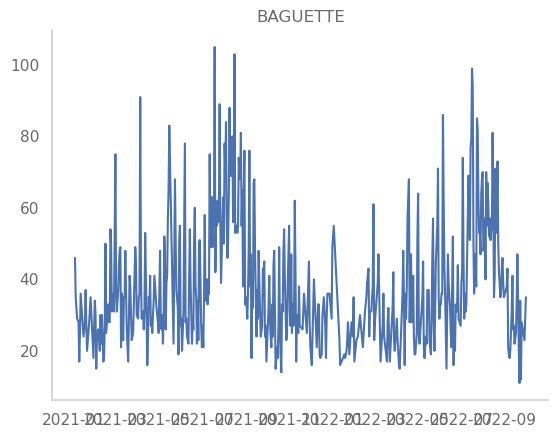

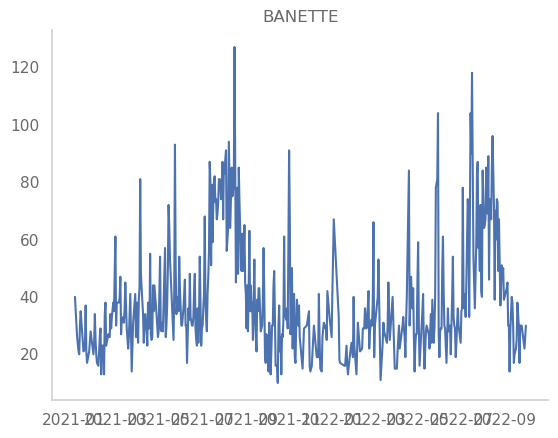

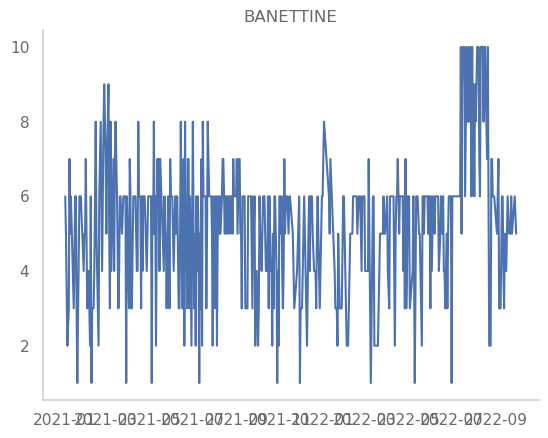

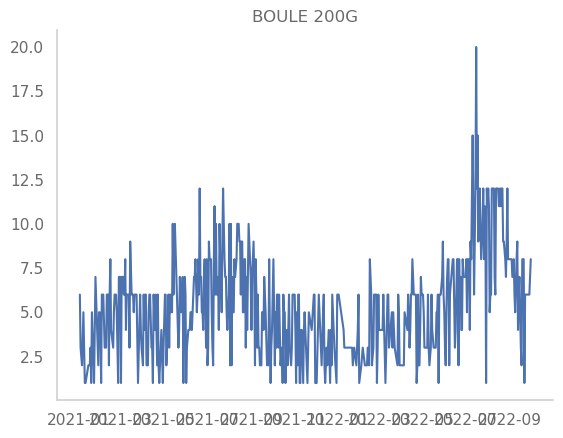

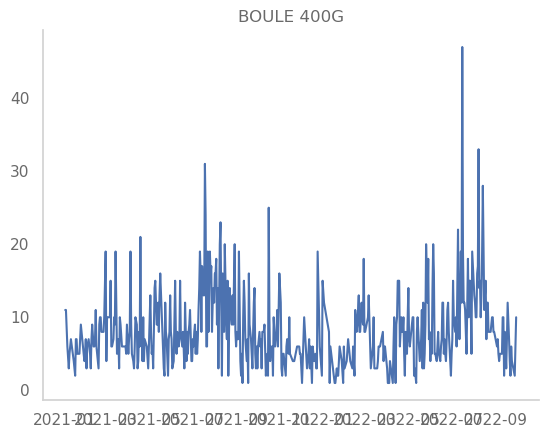

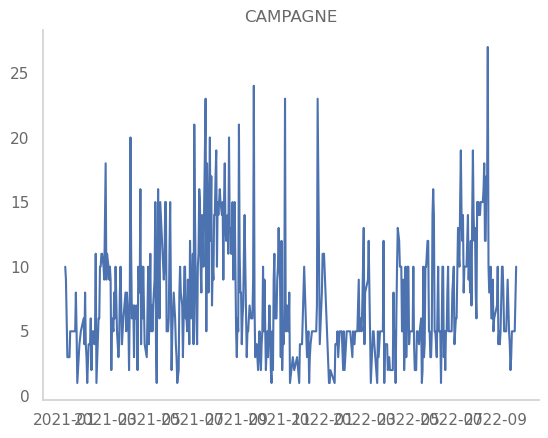

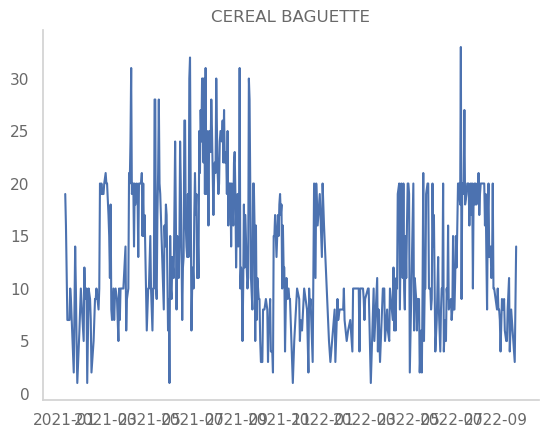

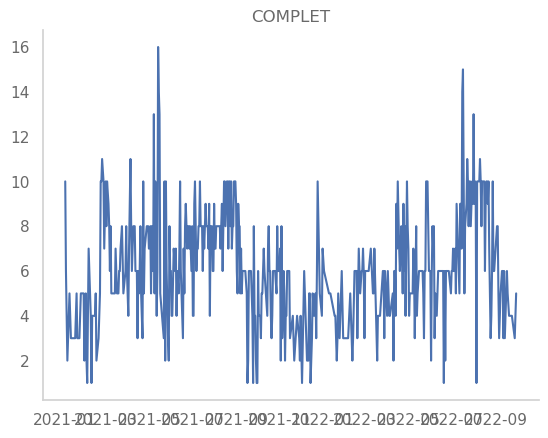

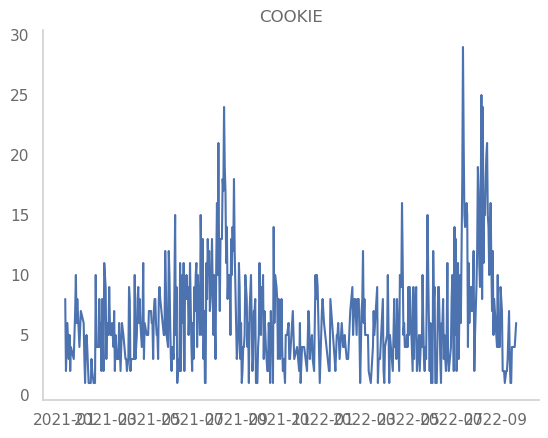

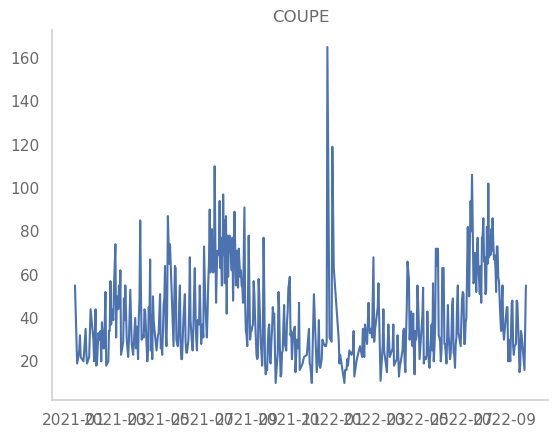

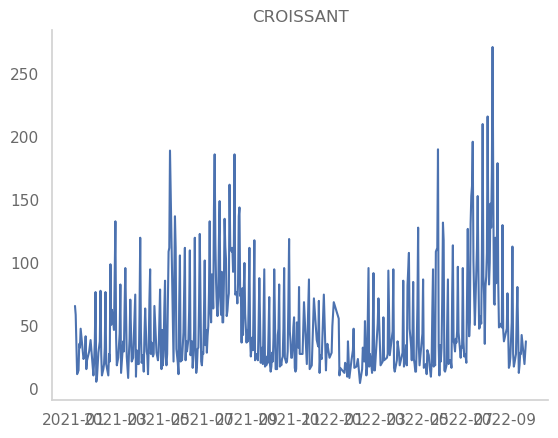

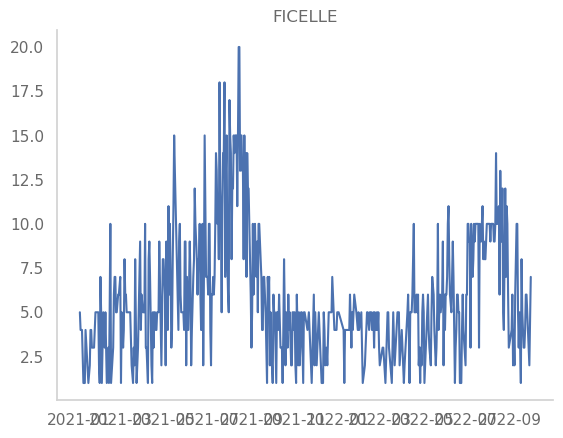

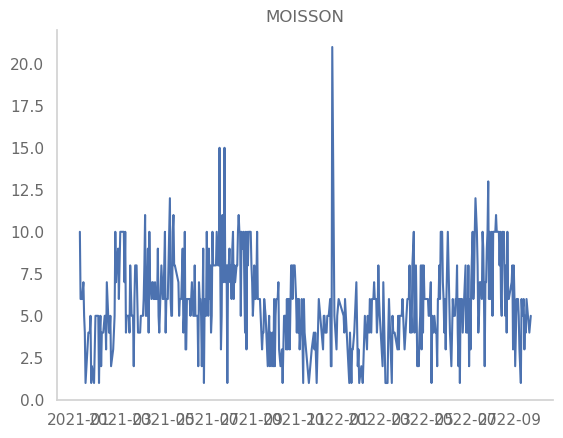

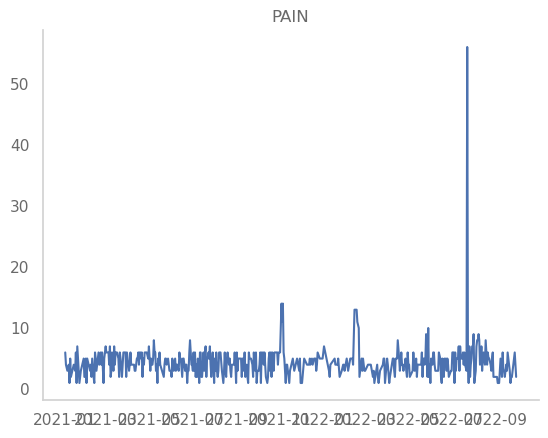

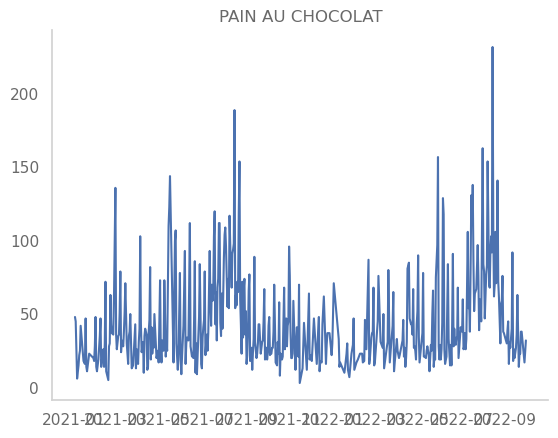

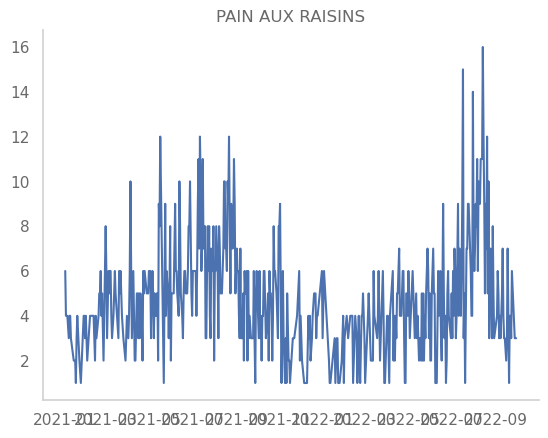

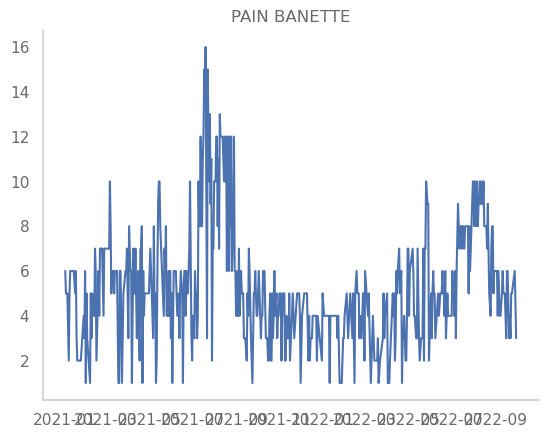

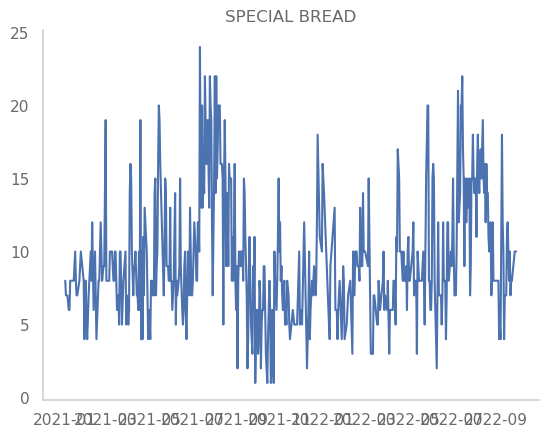

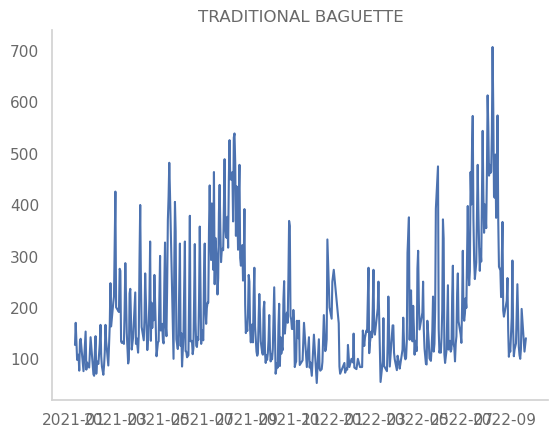

In [15]:
plt.rcParams['font.family'] = 'sans-serif' 
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

### DATA CLEANING REQUIREMENTS
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

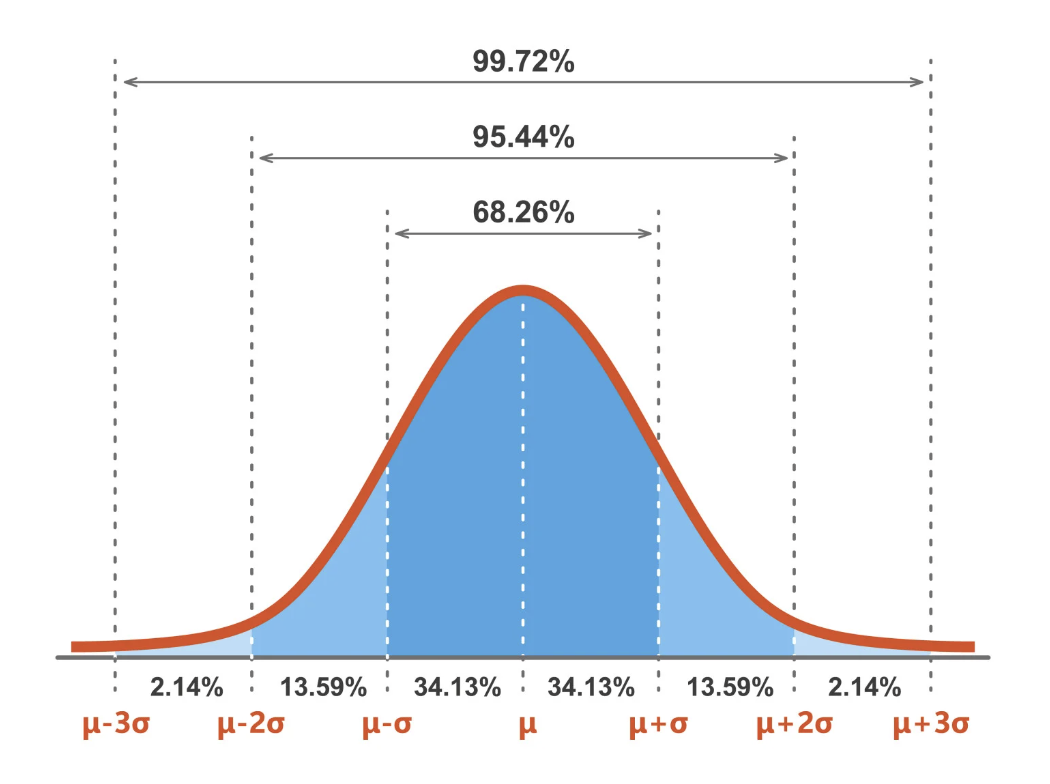

In [16]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 8 rows for following category: BAGUETTE
Dropping 5 rows for following category: BANETTE
Dropping 0 rows for following category: BANETTINE
Dropping 3 rows for following category: BOULE 200G
Dropping 7 rows for following category: BOULE 400G
Dropping 7 rows for following category: CAMPAGNE
Dropping 2 rows for following category: CEREAL BAGUETTE
Dropping 7 rows for following category: COMPLET
Dropping 10 rows for following category: COOKIE
Dropping 5 rows for following category: COUPE
Dropping 10 rows for following category: CROISSANT
Dropping 5 rows for following category: FICELLE
Dropping 3 rows for following category: MOISSON
Dropping 6 rows for following category: PAIN
Dropping 11 rows for following category: PAIN AU CHOCOLAT
Dropping 8 rows for following category: PAIN AUX RAISINS
Dropping 6 rows for following category: PAIN BANETTE
Dropping 6 rows for following category: SPECIAL BREAD
Dropping 9 rows for following category: TRADITIONAL BAGUETTE


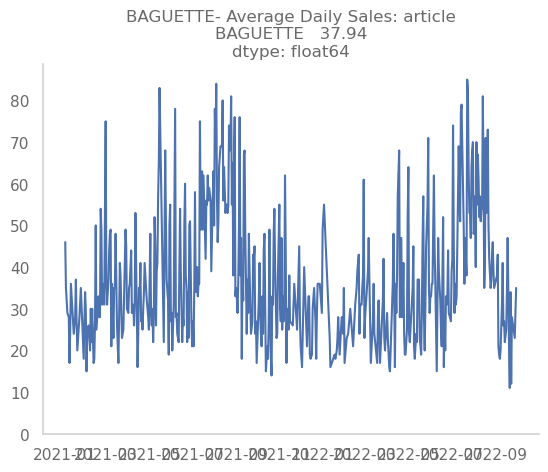

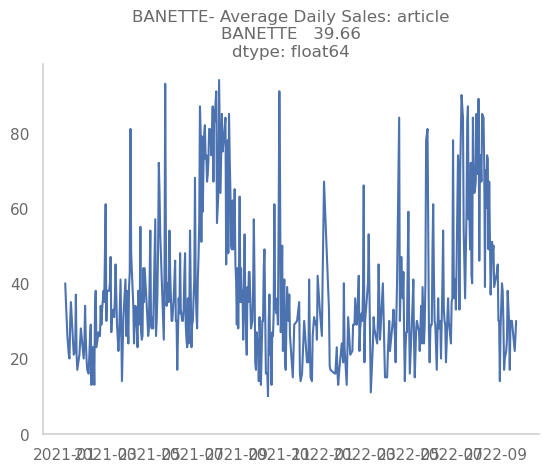

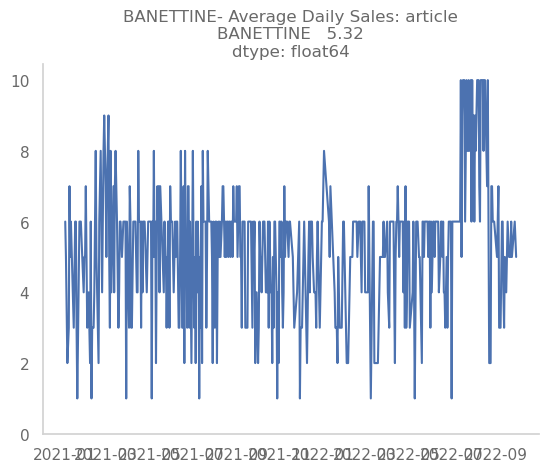

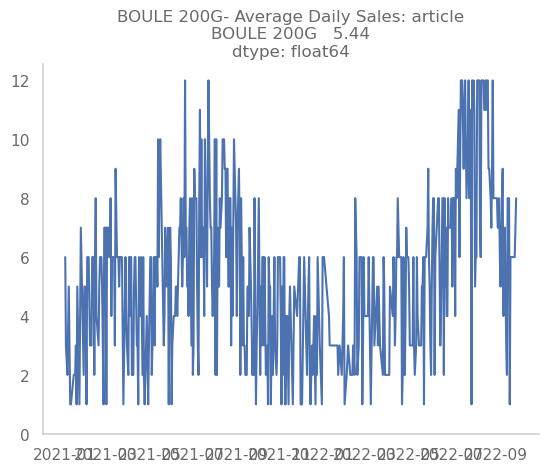

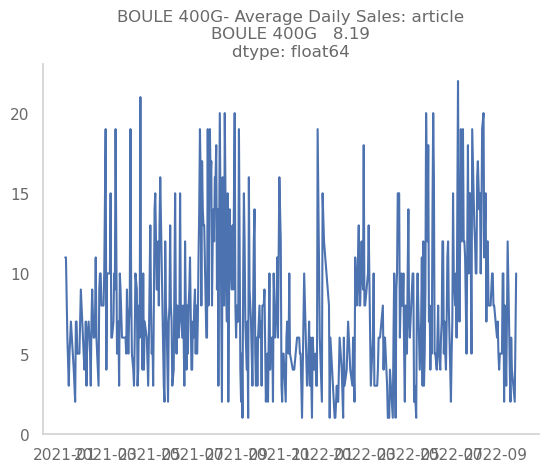

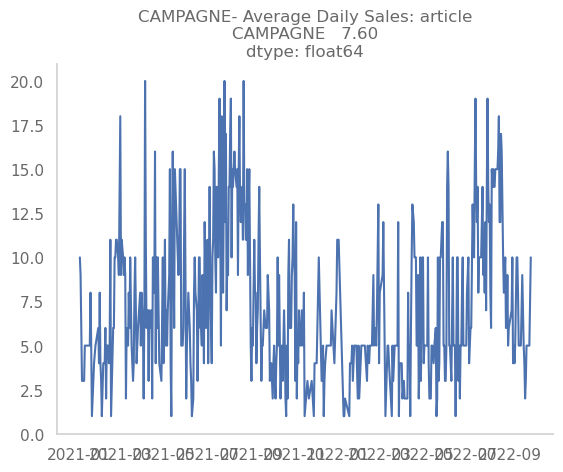

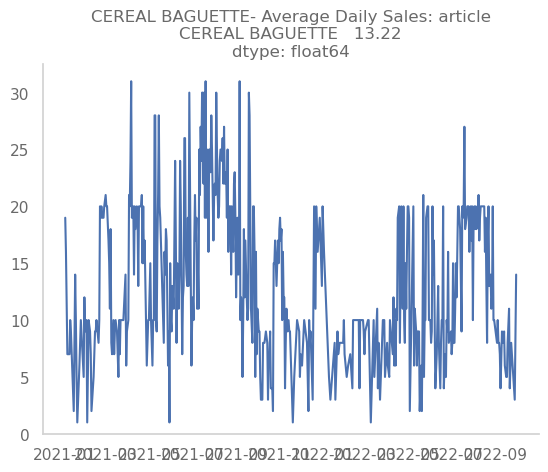

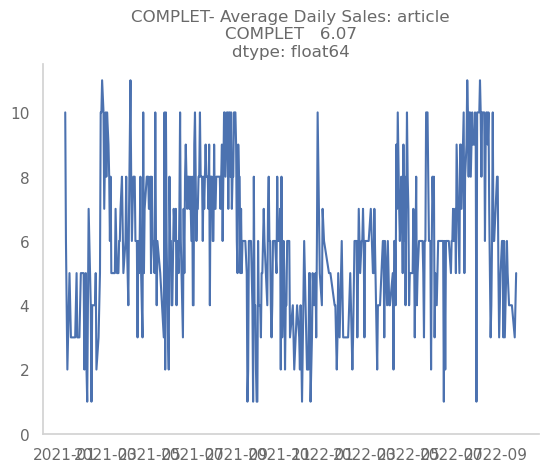

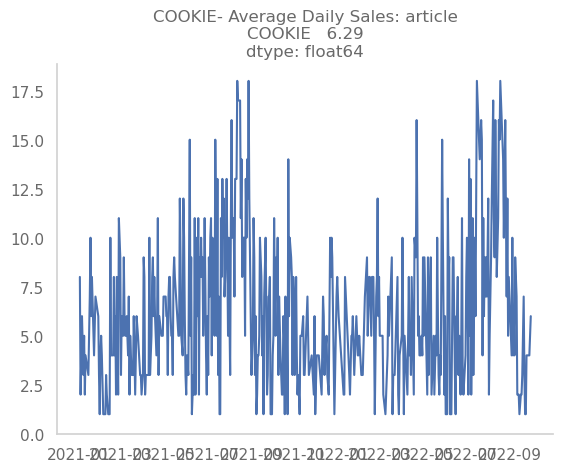

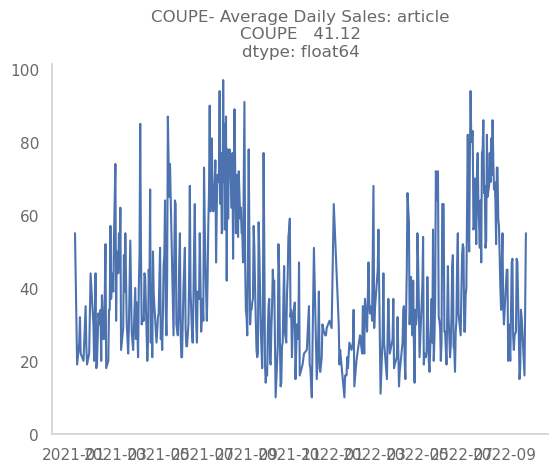

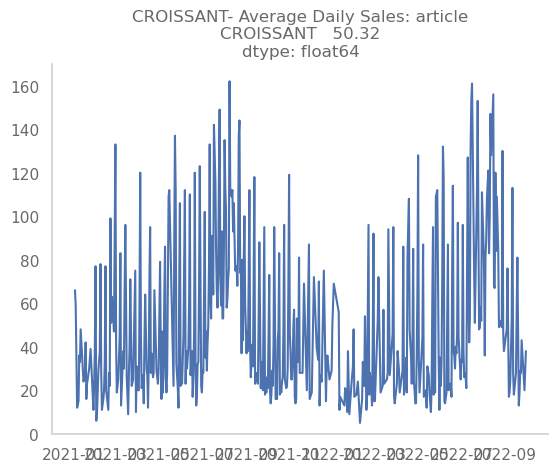

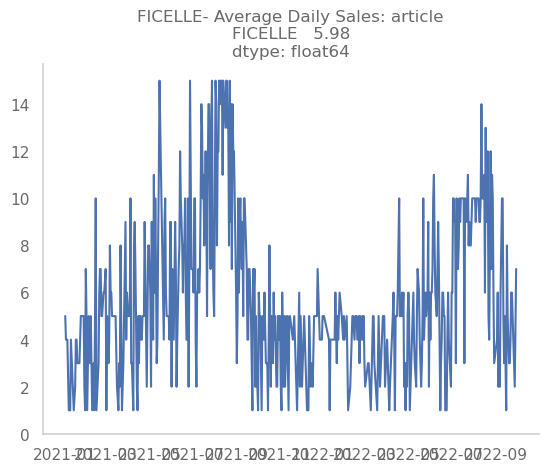

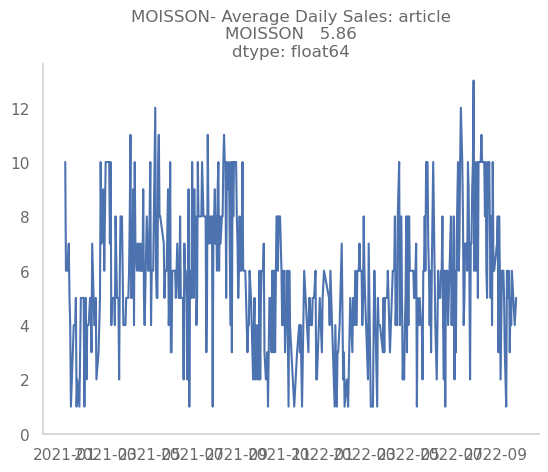

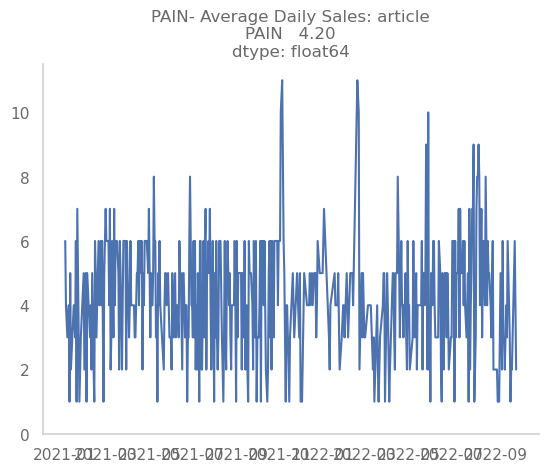

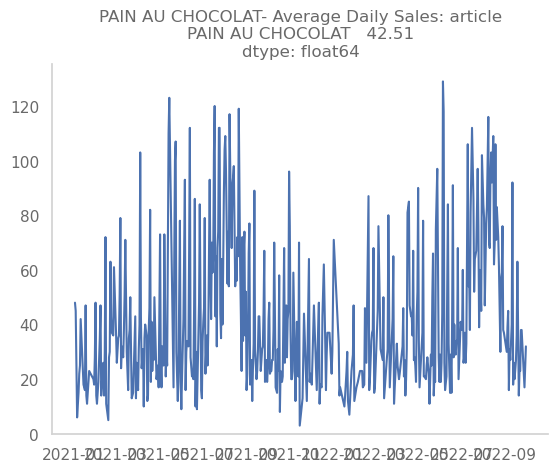

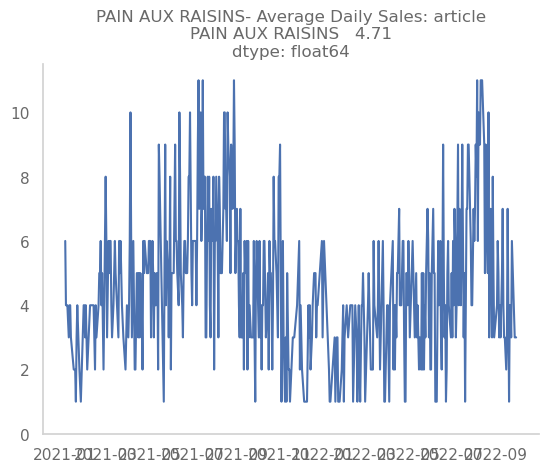

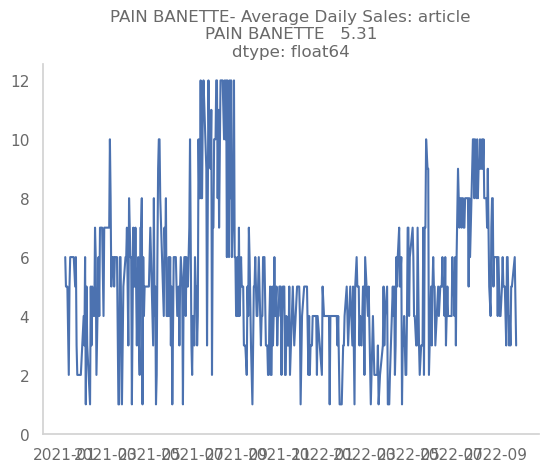

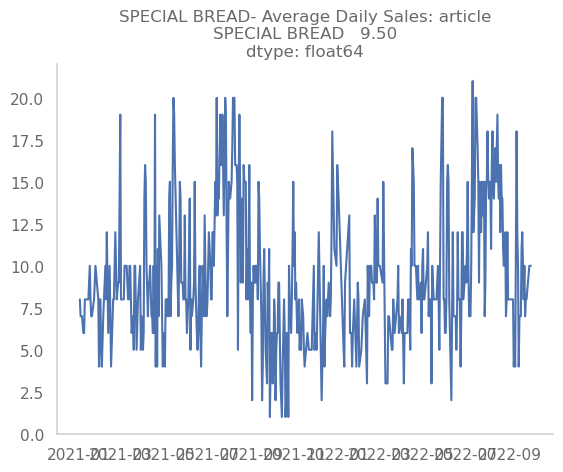

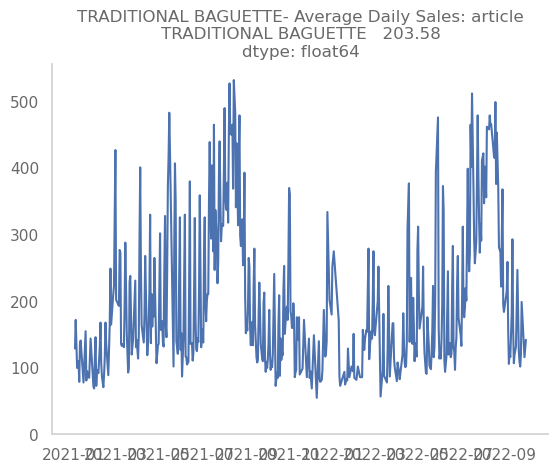

In [17]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

### PLOTTING CATEGORIES

In [18]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [19]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

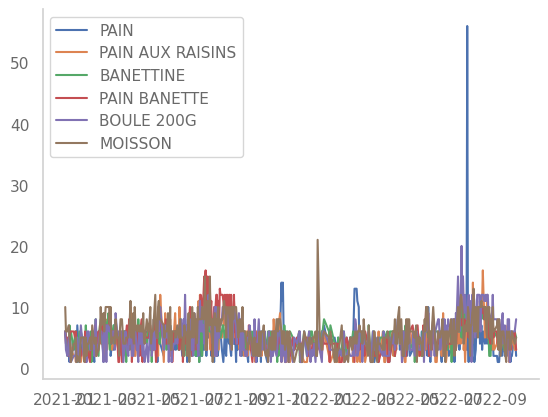

In [20]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

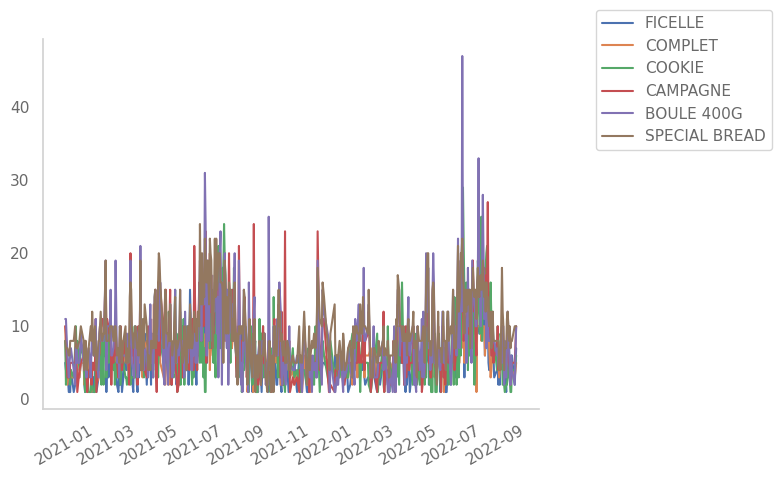

In [21]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

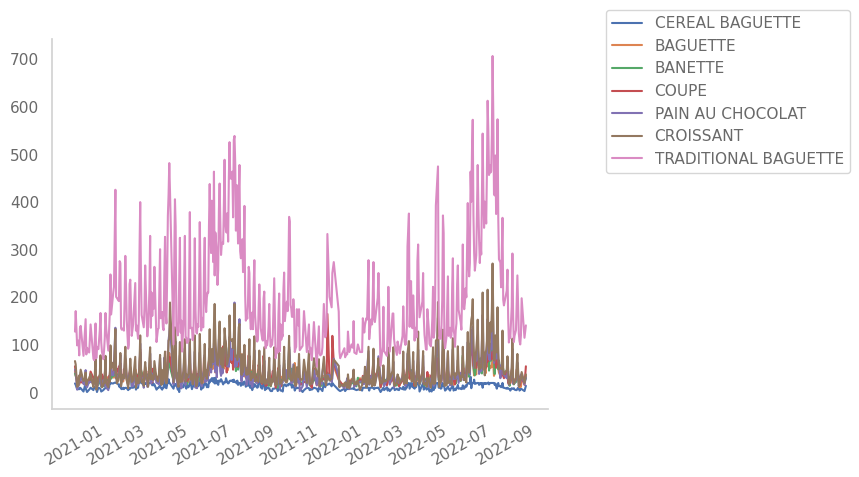

In [22]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [23]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [24]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [25]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 340.15 18.44 13.51  0.36   0.31   0.36      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:16 - cmdstanpy - INFO - Chain [1] done processing
10:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:16 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 362.19 19.03 14.24  0.37   0.31   0.38      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 362.19 19.03 14.24  0.37   0.31   0.38      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:17 - cmdstanpy - INFO - Chain [1] done processing
10:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:17 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 317.05 17.81 13.44  0.36   0.29   0.36      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 - cmdstanpy - INFO - Chain [1] start processing
10:03:18 - cmdstanpy - INFO - Chain [1] done processing
10:03:18 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 362.28 19.03 14.24  0.37   0.31   0.38      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1] done processing
10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:19 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 325.68 18.05 13.14  0.38   0.27   0.34      0.64


10:03:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:19 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 314.60 17.74 13.03  0.38   0.26   0.35      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 319.09 17.86 13.13  0.38   0.27   0.35      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:20 - cmdstanpy - INFO - Chain [1] done processing
10:03:20 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 317.95 17.83 13.11  0.38   0.28   0.35      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 316.69 17.80 13.08  0.38   0.27   0.35      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:21 - cmdstanpy - INFO - Chain [1] done processing
10:03:21 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 324.30 18.01 13.11  0.40   0.26   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 319.05 17.86 13.23  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:22 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 320.03 17.89 13.23  0.40   0.27   0.34      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 315.40 17.76 13.13  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:23 - cmdstanpy - INFO - Chain [1] start processing
10:03:23 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 318.46 17.85 13.19  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 326.71 18.08 13.16  0.41   0.27   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:24 - cmdstanpy - INFO - Chain [1] done processing
10:03:24 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 321.02 17.92 13.26  0.40   0.27   0.34      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 320.22 17.89 13.23  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:25 - cmdstanpy - INFO - Chain [1] done processing
10:03:25 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 320.29 17.90 13.23  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 320.95 17.91 13.25  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 327.98 18.11 13.20  0.41   0.27   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 324.50 18.01 13.35  0.41   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 323.59 17.99 13.27  0.40   0.27   0.34      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 321.83 17.94 13.24  0.40   0.27   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 320.84 17.91 13.25  0.40   0.27   0.33      0.65
BAGUETTE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.36
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 450.25 21.22 15.99  0.46   0.35   0.39      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:30 - cmdstanpy - INFO - Chain [1] done processing
10:03:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:30 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 451.78 21.26 16.05  0.45   0.34   0.39      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:31 - cmdstanpy - INFO - Chain [1] done processing
10:03:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:31 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 451.76 21.25 16.05  0.45   0.34   0.39      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:32 - cmdstanpy - INFO - Chain [1] done processing
10:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:32 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
10:03:33 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 451.74 21.25 16.05  0.45   0.34   0.39      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:33 - cmdstanpy - INFO - Chain [1] done processing
10:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:33 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 451.75 21.25 16.05  0.45   0.34   0.39      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:34 - cmdstanpy - INFO - Chain [1] done processing
10:03:34 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 509.48 22.57 16.16  0.43   0.29   0.38      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 502.20 22.41 16.20  0.44   0.28   0.38      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 494.83 22.24 16.05  0.43   0.28   0.38      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 502.43 22.42 16.23  0.44   0.29   0.39      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:36 - cmdstanpy - INFO - Chain [1] start processing
10:03:36 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 493.81 22.22 15.98  0.43   0.28   0.37      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 530.40 23.03 16.44  0.46   0.29   0.38      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 520.38 22.81 16.40  0.46   0.31   0.38      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 514.94 22.69 16.29  0.45   0.30   0.37      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 515.85 22.71 16.34  0.46   0.30   0.38      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 522.80 22.86 16.46  0.46   0.30   0.38      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 530.60 23.03 16.41  0.47   0.28   0.37      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1] done processing
10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:40 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 522.43 22.86 16.44  0.46   0.31   0.38      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 527.16 22.96 16.49  0.46   0.31   0.38      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:41 - cmdstanpy - INFO - Chain [1] start processing
10:03:41 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 523.29 22.88 16.44  0.46   0.31   0.38      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 525.49 22.92 16.47  0.46   0.31   0.38      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing
10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 532.38 23.07 16.44  0.47   0.28   0.37      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1] done processing
10:03:43 - cmdstanpy - INFO - Chain [1] start processing
10:03:43 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 524.66 22.91 16.48  0.47   0.31   0.38      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 528.08 22.98 16.48  0.47   0.31   0.38      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:44 - cmdstanpy - INFO - Chain [1] done processing
10:03:44 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 528.36 22.99 16.49  0.47   0.31   0.38      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 525.21 22.92 16.43  0.46   0.31   0.38      0.64
BANETTE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.46
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing
10:03:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:45 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:46 - cmdstanpy - INFO - Chain [1] done processing
10:03:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:46 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.76  2.18 1.73  0.36   0.22   0.33      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:46 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:47 - cmdstanpy - INFO - Chain [1] done processing
10:03:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:47 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.77  2.18 1.72  0.36   0.26   0.33      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing
10:03:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:48 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.77  2.18 1.72  0.36   0.26   0.33      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
10:03:49 - cmdstanpy - INFO - Chain [1] done processing
10:03:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:49 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.77  2.18 1.72  0.36   0.26   0.33      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - INFO - Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
10:03:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:03:50 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.77  2.18 1.72  0.36   0.26   0.33      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
10:03:51 - cmdstanpy - INFO - Chain [1] start processing
10:03:51 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 4.96  2.23 1.79  0.41   0.24   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.04  2.24 1.78  0.41   0.26   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1] done processing
10:03:52 - cmdstanpy - INFO - Chain [1] start processing
10:03:52 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.04  2.25 1.78  0.41   0.26   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.10  2.26 1.79  0.41   0.26   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.09  2.26 1.79  0.41   0.26   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:53 - cmdstanpy - INFO - Chain [1] start processing
10:03:53 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.16  2.27 1.82  0.42   0.23   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.20  2.28 1.81  0.42   0.25   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.20  2.28 1.81  0.42   0.24   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:54 - cmdstanpy - INFO - Chain [1] start processing
10:03:54 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.19  2.28 1.81  0.42   0.25   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.21  2.28 1.81  0.42   0.25   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.28  2.30 1.83  0.43   0.23   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.25  2.29 1.81  0.42   0.24   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.29  2.30 1.81  0.42   0.24   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.35  2.31 1.82  0.42   0.24   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.33  2.31 1.82  0.42   0.24   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:57 - cmdstanpy - INFO - Chain [1] done processing
10:03:57 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.24  2.29 1.81  0.43   0.23   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.33  2.31 1.81  0.43   0.24   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:58 - cmdstanpy - INFO - Chain [1] start processing
10:03:58 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.35  2.31 1.81  0.43   0.24   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.35  2.31 1.81  0.43   0.24   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:03:59 - cmdstanpy - INFO - Chain [1] start processing
10:03:59 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.31  2.30 1.81  0.43   0.24   0.33      0.66
BANETTINE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.36
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.36


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 - cmdstanpy - INFO - Chain [1] start processing
10:04:00 - cmdstanpy - INFO - Chain [1] done processing
10:04:00 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 13.13  3.62 2.72  0.53   0.42   0.48      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 - cmdstanpy - INFO - Chain [1] start processing
10:04:01 - cmdstanpy - INFO - Chain [1] done processing
10:04:01 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 12.93  3.60 2.72  0.52   0.40   0.49      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:02 - cmdstanpy - INFO - Chain [1] done processing
10:04:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
10:04:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
10:04:03 - cmdstanpy - INFO - Chain [1] start processing
10:04:03 - cmdstanpy - INFO - Chain [1] done processing
10:04:03 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 12.85  3.58 2.67  0.52   0.40   0.48      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 - cmdstanpy - INFO - Chain [1] start processing
10:04:04 - cmdstanpy - INFO - Chain [1] done processing
10:04:04 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 12.85  3.58 2.67  0.52   0.40   0.48      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:05 - cmdstanpy - INFO - Chain [1] done processing
10:04:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:05 - cmdstanpy - INFO - Chain [1] done processing
10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:05 - cmdstanpy - INFO - Chain [1] done processing
10:04:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:05 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
10:04:06 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 12.85  3.58 2.67  0.52   0.40   0.48      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.55  3.40 2.66  0.53   0.38   0.46      0.57


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.36  3.37 2.60  0.52   0.37   0.47      0.57


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.46  3.39 2.61  0.52   0.37   0.46      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.39  3.37 2.60  0.51   0.38   0.46      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.28  3.36 2.59  0.52   0.37   0.46      0.57


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.33  3.37 2.59  0.55   0.38   0.44      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.15  3.34 2.53  0.53   0.38   0.44      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.10  3.33 2.53  0.53   0.39   0.43      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.08  3.33 2.53  0.53   0.39   0.44      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1] done processing
10:04:10 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.06  3.33 2.52  0.53   0.38   0.43      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.26  3.36 2.56  0.55   0.36   0.43      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1] done processing
10:04:11 - cmdstanpy - INFO - Chain [1] start processing
10:04:11 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.93  3.31 2.48  0.53   0.35   0.42      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.96  3.31 2.49  0.53   0.36   0.42      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1] done processing
10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:12 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.02  3.32 2.49  0.53   0.36   0.42      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:12 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.97  3.31 2.49  0.53   0.36   0.42      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 11.17  3.34 2.53  0.56   0.35   0.42      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:13 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.94  3.31 2.47  0.54   0.35   0.41      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.96  3.31 2.47  0.54   0.35   0.41      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:14 - cmdstanpy - INFO - Chain [1] start processing
10:04:14 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.95  3.31 2.47  0.54   0.36   0.41      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.91  3.30 2.47  0.54   0.35   0.41      0.63
BOULE 200G
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.53
1                     0.00                     2.51  0.52
2                     0.00                     5.00  0.52
3                     0.00                     7.50  0.52
4                     0.00                    10.00  0.52


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing
10:04:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:15 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 38.35  6.19 4.25  0.74   0.41   0.54      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:16 - cmdstanpy - INFO - Chain [1] done processing
10:04:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:16 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 38.07  6.17 4.27  0.74   0.44   0.55      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 - cmdstanpy - INFO - Chain [1] start processing
10:04:17 - cmdstanpy - INFO - Chain [1] done processing
10:04:17 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 38.13  6.17 4.28  0.74   0.44   0.55      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 38.13  6.17 4.28  0.74   0.44   0.55      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 - cmdstanpy - INFO - Chain [1] start processing
10:04:19 - cmdstanpy - INFO - Chain [1] done processing
10:04:19 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 38.08  6.17 4.27  0.74   0.44   0.55      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.77  6.06 4.43  0.76   0.42   0.55      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:20 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.13  6.01 4.37  0.74   0.42   0.55      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.38  6.03 4.39  0.74   0.42   0.56      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1] done processing
10:04:21 - cmdstanpy - INFO - Chain [1] start processing
10:04:21 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.46  6.04 4.39  0.74   0.43   0.56      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.33  6.03 4.39  0.74   0.42   0.56      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 37.05  6.09 4.44  0.80   0.43   0.54      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:22 - cmdstanpy - INFO - Chain [1] start processing
10:04:22 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.50  6.04 4.40  0.79   0.44   0.55      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.30  6.03 4.38  0.79   0.43   0.55      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing
10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.58  6.05 4.41  0.79   0.44   0.55      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.40  6.03 4.39  0.79   0.44   0.55      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1] done processing
10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:24 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.88  6.07 4.43  0.83   0.43   0.53      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.31  6.03 4.40  0.82   0.43   0.54      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.23  6.02 4.39  0.82   0.44   0.54      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:25 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.42  6.04 4.40  0.82   0.44   0.54      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.28  6.02 4.39  0.82   0.43   0.54      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:26 - cmdstanpy - INFO - Chain [1] done processing
10:04:26 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.76  6.06 4.43  0.85   0.44   0.53      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.44  6.04 4.41  0.83   0.44   0.54      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.37  6.03 4.40  0.83   0.44   0.54      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.46  6.04 4.41  0.83   0.44   0.54      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing
10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 36.40  6.03 4.41  0.83   0.44   0.54      0.64
BOULE 400G
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.74
1                     0.00                     2.51  0.74
2                     0.00                     5.00  0.74
3                     0.00                     7.50  0.74
4                     0.00                    10.00  0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 - cmdstanpy - INFO - Chain [1] start processing
10:04:29 - cmdstanpy - INFO - Chain [1] done processing
10:04:29 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.15  4.49 3.43  0.71   0.42   0.49      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 - cmdstanpy - INFO - Chain [1] start processing
10:04:30 - cmdstanpy - INFO - Chain [1] done processing
10:04:30 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.96  4.47 3.37  0.71   0.40   0.48      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 - cmdstanpy - INFO - Chain [1] start processing
10:04:31 - cmdstanpy - INFO - Chain [1] done processing
10:04:31 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.02  4.47 3.38  0.71   0.40   0.48      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:32 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.99  4.47 3.37  0.71   0.40   0.48      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 - cmdstanpy - INFO - Chain [1] start processing
10:04:33 - cmdstanpy - INFO - Chain [1] done processing
10:04:33 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.99  4.47 3.37  0.71   0.40   0.48      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:34 - cmdstanpy - INFO - Chain [1] done processing
10:04:34 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 22.90  4.79 3.78  0.65   0.46   0.56      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 22.28  4.72 3.74  0.65   0.47   0.58      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 22.47  4.74 3.76  0.65   0.46   0.58      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:35 - cmdstanpy - INFO - Chain [1] start processing
10:04:35 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 22.43  4.74 3.75  0.65   0.46   0.58      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 22.65  4.76 3.77  0.65   0.46   0.59      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.81  4.67 3.66  0.70   0.41   0.52      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.63  4.65 3.65  0.71   0.42   0.53      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1] done processing
10:04:37 - cmdstanpy - INFO - Chain [1] start processing
10:04:37 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.64  4.65 3.65  0.71   0.42   0.53      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.18  4.60 3.62  0.70   0.41   0.53      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.52  4.64 3.64  0.70   0.41   0.53      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:38 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.72  4.66 3.67  0.74   0.40   0.50      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.43  4.63 3.61  0.73   0.40   0.51      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:39 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.55  4.64 3.63  0.73   0.40   0.51      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.43  4.63 3.61  0.73   0.40   0.51      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:40 - cmdstanpy - INFO - Chain [1] done processing
10:04:40 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.33  4.62 3.60  0.72   0.39   0.51      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.98  4.69 3.70  0.77   0.40   0.50      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:41 - cmdstanpy - INFO - Chain [1] done processing
10:04:41 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.86  4.67 3.65  0.76   0.39   0.51      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.74  4.66 3.64  0.75   0.39   0.51      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:42 - cmdstanpy - INFO - Chain [1] done processing
10:04:42 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.85  4.67 3.65  0.76   0.39   0.51      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 21.67  4.65 3.63  0.75   0.39   0.50      0.66
CAMPAGNE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.71
2                     0.00                     5.00  0.71
3                     0.00                     7.50  0.71
4                     0.00                    10.00  0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:43 - cmdstanpy - INFO - Chain [1] start processing
10:04:43 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 47.81  6.91 5.43  0.60   0.39   0.49      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 - cmdstanpy - INFO - Chain [1] start processing
10:04:44 - cmdstanpy - INFO - Chain [1] done processing
10:04:44 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 48.78  6.98 5.51  0.60   0.40   0.50      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing
10:04:45 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 48.78  6.98 5.51  0.60   0.40   0.50      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:46 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 48.78  6.98 5.51  0.60   0.40   0.50      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 48.74  6.98 5.51  0.60   0.40   0.50      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 46.08  6.79 5.40  0.59   0.44   0.51      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 46.12  6.79 5.34  0.58   0.38   0.51      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 46.57  6.82 5.37  0.58   0.39   0.52      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 46.82  6.84 5.38  0.58   0.39   0.52      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 46.27  6.80 5.34  0.58   0.39   0.51      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 42.85  6.55 5.20  0.62   0.38   0.46      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 42.92  6.55 5.15  0.61   0.39   0.47      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.39  6.59 5.21  0.62   0.40   0.47      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:51 - cmdstanpy - INFO - Chain [1] done processing
10:04:51 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 42.85  6.55 5.14  0.60   0.38   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.28  6.58 5.18  0.61   0.39   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1] done processing
10:04:52 - cmdstanpy - INFO - Chain [1] start processing
10:04:52 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.44  6.59 5.26  0.65   0.38   0.46      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.38  6.59 5.22  0.64   0.40   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1] done processing
10:04:53 - cmdstanpy - INFO - Chain [1] start processing
10:04:53 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.61  6.60 5.25  0.64   0.39   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.97  6.63 5.27  0.64   0.41   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1] done processing
10:04:54 - cmdstanpy - INFO - Chain [1] start processing
10:04:54 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.73  6.61 5.25  0.64   0.41   0.47      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.67  6.61 5.30  0.67   0.39   0.46      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1] done processing
10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:55 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 44.25  6.65 5.32  0.66   0.40   0.47      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:55 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 44.24  6.65 5.33  0.66   0.40   0.47      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 43.88  6.62 5.30  0.66   0.40   0.47      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:56 - cmdstanpy - INFO - Chain [1] start processing
10:04:56 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 44.25  6.65 5.34  0.67   0.39   0.47      0.68
CEREAL BAGUETTE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.60
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.60
3                     0.00                     7.50  0.60
4                     0.00                    10.00  0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 - cmdstanpy - INFO - Chain [1] start processing
10:04:57 - cmdstanpy - INFO - Chain [1] done processing
10:04:57 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.19  3.03 2.39  0.43   0.35   0.46      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:58 - cmdstanpy - INFO - Chain [1] done processing
10:04:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:58 - cmdstanpy - INFO - Chain [1] done processing
10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:58 - cmdstanpy - INFO - Chain [1] done processing
10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:58 - cmdstanpy - INFO - Chain [1] done processing
10:04:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:04:58 - cmdstanpy - INFO - Chain [1] start processing
10:04:59 - cmdstanpy - INFO - Chain [1] done processing
10:04:59 - cmdstanpy - INFO - Chain [1] start processing
10:04:59 - cmdstanpy - INFO - Chain [1] done processing
10:04:59 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.37  3.06 2.45  0.44   0.36   0.48      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 - cmdstanpy - INFO - Chain [1] start processing
10:05:00 - cmdstanpy - INFO - Chain [1] done processing
10:05:00 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.37  3.06 2.45  0.44   0.36   0.48      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 - cmdstanpy - INFO - Chain [1] start processing
10:05:01 - cmdstanpy - INFO - Chain [1] done processing
10:05:01 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.08  3.01 2.38  0.43   0.35   0.46      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:02 - cmdstanpy - INFO - Chain [1] start processing
10:05:02 - cmdstanpy - INFO - Chain [1] done processing
10:05:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:02 - cmdstanpy - INFO - Chain [1] start processing
10:05:02 - cmdstanpy - INFO - Chain [1] done processing
10:05:02 - cmdstanpy - INFO - Chain [1] start processing
10:05:02 - cmdstanpy - INFO - Chain [1] done processing
10:05:02 - cmdstanpy - INFO - Chain [1] start processing
10:05:02 - cmdstanpy - INFO - Chain [1] done processing
10:05:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:02 - cmdstanpy - INFO - Chain [1] start processing
10:05:03 - cmdstanpy - INFO - Chain [1] done processing
10:05:03 - cmdstanpy - INFO - Chain [1] start processing
10:05:03 - cmdstanpy - INFO - Chain [1] done processing
10:05:03 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.37  3.06 2.45  0.43   0.36   0.48      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.32  2.70 2.10  0.43   0.27   0.35      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.35  2.71 2.11  0.43   0.26   0.36      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:04 - cmdstanpy - INFO - Chain [1] start processing
10:05:04 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.34  2.71 2.11  0.43   0.27   0.36      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.33  2.71 2.11  0.43   0.27   0.36      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.38  2.72 2.11  0.43   0.26   0.36      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.98  2.64 2.06  0.44   0.24   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:06 - cmdstanpy - INFO - Chain [1] done processing
10:05:06 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.01  2.65 2.05  0.43   0.24   0.34      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.99  2.64 2.05  0.43   0.24   0.34      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.08  2.66 2.06  0.44   0.24   0.34      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:07 - cmdstanpy - INFO - Chain [1] start processing
10:05:07 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.03  2.65 2.05  0.43   0.24   0.34      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.98  2.64 2.05  0.44   0.24   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:08 - cmdstanpy - INFO - Chain [1] done processing
10:05:08 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.65 2.05  0.44   0.24   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.06  2.66 2.05  0.44   0.25   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:09 - cmdstanpy - INFO - Chain [1] start processing
10:05:09 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.02  2.65 2.05  0.44   0.26   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.65 2.05  0.44   0.25   0.34      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:10 - cmdstanpy - INFO - Chain [1] done processing
10:05:10 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.04  2.65 2.06  0.45   0.24   0.34      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.01  2.65 2.04  0.45   0.25   0.34      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:11 - cmdstanpy - INFO - Chain [1] start processing
10:05:11 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.02  2.65 2.05  0.45   0.25   0.34      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1] done processing
10:05:12 - cmdstanpy - INFO - Chain [1] start processing
10:05:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.05  2.66 2.05  0.45   0.25   0.34      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.99  2.64 2.04  0.44   0.25   0.33      0.69
COMPLET
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.43
1                     0.00                     2.51  0.44
2                     0.00                     5.00  0.44
3                     0.00                     7.50  0.43
4                     0.00                    10.00  0.43


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - INFO - Chain [1] start processing
10:05:13 - cmdstanpy - INFO - Chain [1] done processing
10:05:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:13 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 25.24  5.02 3.67  0.86   0.44   0.56      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - INFO - Chain [1] start processing
10:05:14 - cmdstanpy - INFO - Chain [1] done processing
10:05:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:14 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 25.05  5.00 3.67  0.86   0.44   0.57      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:15 - cmdstanpy - INFO - Chain [1] done processing
10:05:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - INFO - Chain [1] start processing
10:05:16 - cmdstanpy - INFO - Chain [1] done processing
10:05:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:16 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 25.05  5.00 3.67  0.86   0.44   0.57      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing
10:05:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:17 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 25.05  5.00 3.67  0.86   0.44   0.57      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - INFO - Chain [1] start processing
10:05:18 - cmdstanpy - INFO - Chain [1] done processing
10:05:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:18 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 25.05  5.00 3.67  0.86   0.44   0.57      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing
10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing
10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing
10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:19 - cmdstanpy - INFO - Chain [1] done processing
10:05:19 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 32.65  5.71 4.28  1.09   0.52   0.63      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.51  5.79 4.34  1.10   0.52   0.64      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.34  5.77 4.33  1.10   0.52   0.64      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.50  5.79 4.34  1.10   0.52   0.64      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.43  5.78 4.33  1.10   0.52   0.64      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:22 - cmdstanpy - INFO - Chain [1] done processing
10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.66  5.80 4.31  1.19   0.48   0.61      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.98  5.83 4.32  1.20   0.49   0.61      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:23 - cmdstanpy - INFO - Chain [1] start processing
10:05:23 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 34.07  5.84 4.31  1.20   0.49   0.61      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 34.28  5.86 4.32  1.20   0.49   0.61      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:24 - cmdstanpy - INFO - Chain [1] done processing
10:05:24 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.41  5.78 4.29  1.19   0.49   0.61      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 34.28  5.85 4.32  1.23   0.47   0.60      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.44  5.78 4.28  1.22   0.46   0.60      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.96  5.83 4.30  1.22   0.47   0.60      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.93  5.82 4.30  1.22   0.47   0.60      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.58  5.79 4.29  1.22   0.46   0.60      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 34.04  5.83 4.31  1.24   0.47   0.60      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.61  5.80 4.29  1.22   0.46   0.60      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.79  5.81 4.29  1.23   0.46   0.60      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 34.09  5.84 4.31  1.23   0.46   0.60      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 33.90  5.82 4.29  1.23   0.46   0.60      0.63
COOKIE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.86
1                     0.00                     2.51  0.86
2                     0.00                     5.00  0.86
3                     0.00                     7.50  0.86
4                     0.00                    10.00  0.86


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1] done processing
10:05:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:29 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing
10:05:30 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing
10:05:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:30 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing
10:05:30 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing
10:05:30 - cmdstanpy - INFO - Chain [1] start processing
10:05:30 - cmdstanpy - INFO - Chain [1] done processing
10:05:30 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 431.72 20.78 15.77  0.40   0.34   0.40      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing
10:05:31 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 445.68 21.11 15.81  0.39   0.33   0.41      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 - cmdstanpy - INFO - Chain [1] start processing
10:05:32 - cmdstanpy - INFO - Chain [1] done processing
10:05:32 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 440.82 21.00 15.72  0.39   0.33   0.41      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 - cmdstanpy - INFO - Chain [1] start processing
10:05:33 - cmdstanpy - INFO - Chain [1] done processing
10:05:33 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 443.51 21.06 15.76  0.39   0.33   0.41      0.75


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
10:05:34 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 439.71 20.97 15.70  0.39   0.33   0.40      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:34 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 464.54 21.55 16.27  0.46   0.32   0.39      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 470.60 21.69 16.38  0.46   0.34   0.39      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:35 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 471.89 21.72 16.44  0.46   0.34   0.39      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 465.99 21.59 16.29  0.46   0.33   0.39      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:36 - cmdstanpy - INFO - Chain [1] done processing
10:05:36 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 468.22 21.64 16.36  0.46   0.35   0.39      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 487.44 22.08 16.70  0.50   0.33   0.39      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:37 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 485.27 22.03 16.64  0.49   0.33   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 484.98 22.02 16.64  0.49   0.33   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 487.20 22.07 16.66  0.49   0.34   0.39      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 482.73 21.97 16.60  0.49   0.34   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing
10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 494.39 22.23 16.81  0.51   0.34   0.39      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 497.00 22.29 16.86  0.51   0.33   0.39      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:40 - cmdstanpy - INFO - Chain [1] done processing
10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 497.42 22.30 16.85  0.50   0.32   0.39      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 494.64 22.24 16.82  0.50   0.33   0.39      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 494.52 22.24 16.81  0.50   0.33   0.39      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 495.40 22.26 16.80  0.51   0.34   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 497.52 22.31 16.82  0.51   0.33   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 496.76 22.29 16.85  0.51   0.33   0.39      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 497.71 22.31 16.85  0.51   0.33   0.39      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 497.71 22.31 16.84  0.51   0.33   0.39      0.64
COUPE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.40
1                     0.00                     2.51  0.39
2                     0.00                     5.00  0.39
3                     0.00                     7.50  0.39
4                     0.00                    10.00  0.39


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1969.85 44.38 29.79  0.66   0.45   0.55      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing
10:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1743.41 41.75 28.04  0.59   0.44   0.56      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1743.07 41.75 28.04  0.59   0.44   0.56      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:47 - cmdstanpy - INFO - Chain [1] done processing
10:05:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:47 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1743.66 41.76 28.04  0.59   0.44   0.56      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1743.66 41.76 28.05  0.59   0.44   0.56      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:49 - cmdstanpy - INFO - Chain [1] start processing
10:05:49 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1824.35 42.71 29.66  0.68   0.46   0.53      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1600.24 40.00 27.78  0.65   0.44   0.55      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1] done processing
10:05:50 - cmdstanpy - INFO - Chain [1] start processing
10:05:50 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1633.17 40.41 28.04  0.66   0.45   0.55      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1643.17 40.54 28.10  0.66   0.44   0.56      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1623.58 40.29 27.96  0.66   0.45   0.55      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:51 - cmdstanpy - INFO - Chain [1] start processing
10:05:51 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1814.90 42.60 29.06  0.71   0.40   0.48      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1647.93 40.59 27.80  0.68   0.39   0.49      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
10:05:52 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1654.57 40.68 27.77  0.67   0.40   0.49      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1642.03 40.52 27.74  0.67   0.40   0.49      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:53 - cmdstanpy - INFO - Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1649.02 40.61 27.72  0.67   0.39   0.49      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1805.32 42.49 29.23  0.74   0.42   0.48      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:54 - cmdstanpy - INFO - Chain [1] start processing
10:05:54 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1652.07 40.65 27.71  0.68   0.39   0.48      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1652.81 40.65 27.78  0.68   0.40   0.48      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:55 - cmdstanpy - INFO - Chain [1] done processing
10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1654.70 40.68 27.77  0.68   0.40   0.48      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1658.03 40.72 27.76  0.68   0.39   0.48      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:56 - cmdstanpy - INFO - Chain [1] done processing
10:05:56 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1822.59 42.69 29.27  0.74   0.41   0.48      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1] done processing
10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:57 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1671.12 40.88 27.92  0.69   0.39   0.48      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:57 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1659.49 40.74 27.80  0.69   0.40   0.48      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:58 - cmdstanpy - INFO - Chain [1] done processing
10:05:58 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1668.39 40.85 27.86  0.69   0.39   0.48      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1668.03 40.84 27.90  0.69   0.40   0.48      0.67
CROISSANT
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.66
1                     0.00                     2.51  0.59
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing
10:05:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:00 - cmdstanpy - INFO - Chain [1] done processing
10:06:00 - cmdstanpy - INFO - Chain [1] start processing
10:06:00 - cmdstanpy - INFO - Chain [1] done processing
10:06:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.02  3.00 2.51  0.77   0.38   0.46      0.91


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:01 - cmdstanpy - INFO - Chain [1] start processing
10:06:01 - cmdstanpy - INFO - Chain [1] done processing
10:06:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:01 - cmdstanpy - INFO - Chain [1] start processing
10:06:01 - cmdstanpy - INFO - Chain [1] done processing
10:06:01 - cmdstanpy - INFO - Chain [1] start processing
10:06:01 - cmdstanpy - INFO - Chain [1] done processing
10:06:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:01 - cmdstanpy - INFO - Chain [1] start processing
10:06:01 - cmdstanpy - INFO - Chain [1] done processing
10:06:01 - cmdstanpy - INFO - Chain [1] start processing
10:06:01 - cmdstanpy - INFO - Chain [1] done processing
10:06:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.00  3.00 2.49  0.76   0.38   0.46      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:02 - cmdstanpy - INFO - Chain [1] start processing
10:06:02 - cmdstanpy - INFO - Chain [1] done processing
10:06:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:02 - cmdstanpy - INFO - Chain [1] start processing
10:06:03 - cmdstanpy - INFO - Chain [1] done processing
10:06:03 - cmdstanpy - INFO - Chain [1] start processing
10:06:03 - cmdstanpy - INFO - Chain [1] done processing
10:06:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:03 - cmdstanpy - INFO - Chain [1] start processing
10:06:03 - cmdstanpy - INFO - Chain [1] done processing
10:06:03 - cmdstanpy - INFO - Chain [1] start processing
10:06:03 - cmdstanpy - INFO - Chain [1] done processing
10:06:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.01  3.00 2.49  0.76   0.38   0.46      0.90


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:04 - cmdstanpy - INFO - Chain [1] start processing
10:06:04 - cmdstanpy - INFO - Chain [1] done processing
10:06:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:04 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:05 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.98  3.00 2.49  0.76   0.38   0.46      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.99  3.00 2.49  0.76   0.38   0.46      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.33  3.21 2.63  0.65   0.42   0.54      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1] done processing
10:06:08 - cmdstanpy - INFO - Chain [1] start processing
10:06:08 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.30  3.21 2.60  0.62   0.40   0.53      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.27  3.21 2.60  0.62   0.41   0.54      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.45  3.23 2.61  0.62   0.40   0.54      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 10.16  3.19 2.58  0.62   0.39   0.53      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.54  3.09 2.41  0.65   0.35   0.45      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:10 - cmdstanpy - INFO - Chain [1] start processing
10:06:10 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.56  3.09 2.44  0.63   0.36   0.46      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.54  3.09 2.44  0.63   0.36   0.45      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:11 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.56  3.09 2.44  0.63   0.37   0.46      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1] done processing
10:06:12 - cmdstanpy - INFO - Chain [1] start processing
10:06:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.48  3.08 2.43  0.63   0.36   0.46      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.46  3.08 2.37  0.65   0.34   0.43      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:13 - cmdstanpy - INFO - Chain [1] done processing
10:06:13 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.43  3.07 2.41  0.64   0.35   0.45      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.48  3.08 2.41  0.63   0.35   0.45      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing
10:06:14 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.46  3.08 2.40  0.63   0.35   0.44      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.40  3.07 2.40  0.64   0.34   0.44      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:15 - cmdstanpy - INFO - Chain [1] start processing
10:06:15 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.36  3.06 2.35  0.65   0.34   0.43      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.44  3.07 2.39  0.64   0.34   0.44      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:16 - cmdstanpy - INFO - Chain [1] start processing
10:06:16 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.38  3.06 2.39  0.64   0.34   0.44      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.45  3.07 2.40  0.64   0.34   0.44      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:17 - cmdstanpy - INFO - Chain [1] done processing
10:06:17 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.39  3.06 2.39  0.64   0.33   0.44      0.71
FICELLE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.77
1                     0.00                     2.51  0.76
2                     0.00                     5.00  0.76
3                     0.00                     7.50  0.76
4                     0.00                    10.00  0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 - cmdstanpy - INFO - Chain [1] start processing
10:06:18 - cmdstanpy - INFO - Chain [1] done processing
10:06:18 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.96  3.16 2.55  0.54   0.41   0.53      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 - cmdstanpy - INFO - Chain [1] start processing
10:06:19 - cmdstanpy - INFO - Chain [1] done processing
10:06:19 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.75  3.12 2.52  0.54   0.41   0.52      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:20 - cmdstanpy - INFO - Chain [1] start processing
10:06:20 - cmdstanpy - INFO - Chain [1] done processing
10:06:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:20 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing
10:06:21 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing
10:06:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:21 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing
10:06:21 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing
10:06:21 - cmdstanpy - INFO - Chain [1] start processing
10:06:21 - cmdstanpy - INFO - Chain [1] done processing
10:06:21 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.41  3.07 2.49  0.53   0.41   0.51      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:22 - cmdstanpy - INFO - Chain [1] start processing
10:06:22 - cmdstanpy - INFO - Chain [1] done processing
10:06:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:22 - cmdstanpy - INFO - Chain [1] start processing
10:06:23 - cmdstanpy - INFO - Chain [1] done processing
10:06:23 - cmdstanpy - INFO - Chain [1] start processing
10:06:23 - cmdstanpy - INFO - Chain [1] done processing
10:06:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:23 - cmdstanpy - INFO - Chain [1] start processing
10:06:23 - cmdstanpy - INFO - Chain [1] done processing
10:06:23 - cmdstanpy - INFO - Chain [1] start processing
10:06:23 - cmdstanpy - INFO - Chain [1] done processing
10:06:23 - cmdstanpy - INFO - Chain [1] start processing
10:06:23 - cmdstanpy - INFO - Chain [1] done processing
10:06:23 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.07  3.01 2.42  0.54   0.39   0.48      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing
10:06:24 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 9.24  3.04 2.47  0.53   0.39   0.51      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:25 - cmdstanpy - INFO - Chain [1] done processing
10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:25 - cmdstanpy - INFO - Chain [1] done processing
10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.14  2.67 2.18  0.54   0.33   0.42      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.21  2.69 2.19  0.53   0.32   0.42      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:26 - cmdstanpy - INFO - Chain [1] start processing
10:06:26 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.21  2.69 2.19  0.53   0.32   0.42      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.23  2.69 2.19  0.53   0.33   0.42      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.23  2.69 2.19  0.53   0.33   0.42      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:27 - cmdstanpy - INFO - Chain [1] start processing
10:06:27 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.94  2.63 2.13  0.57   0.32   0.40      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.97  2.64 2.14  0.56   0.32   0.40      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:28 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.99  2.64 2.14  0.57   0.32   0.40      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.65 2.15  0.56   0.32   0.40      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:29 - cmdstanpy - INFO - Chain [1] done processing
10:06:29 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.65 2.15  0.56   0.32   0.40      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.64 2.13  0.59   0.30   0.40      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing
10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.03  2.65 2.14  0.58   0.30   0.40      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.04  2.65 2.14  0.58   0.30   0.40      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1] done processing
10:06:31 - cmdstanpy - INFO - Chain [1] start processing
10:06:31 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.97  2.64 2.13  0.58   0.30   0.40      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.00  2.65 2.14  0.58   0.30   0.40      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1] done processing
10:06:32 - cmdstanpy - INFO - Chain [1] start processing
10:06:32 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.06  2.66 2.14  0.59   0.30   0.39      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.04  2.65 2.14  0.59   0.30   0.40      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1] done processing
10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:06:33 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.08  2.66 2.15  0.59   0.30   0.40      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.06  2.66 2.14  0.59   0.30   0.40      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1] done processing
10:06:34 - cmdstanpy - INFO - Chain [1] start processing
10:06:34 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.05  2.65 2.14  0.59   0.29   0.40      0.70
MOISSON
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.54
1                     0.00                     2.51  0.54
2                     0.00                     5.00  0.53
3                     0.00                     7.50  0.54
4                     0.00                    10.00  0.53


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:35 - cmdstanpy - INFO - Chain [1] start processing
10:06:35 - cmdstanpy - INFO - Chain [1] done processing
10:06:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:35 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:36 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.35  4.40 2.00  0.54   0.33   0.44      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - INFO - Chain [1] start processing
10:06:36 - cmdstanpy - INFO - Chain [1] done processing
10:06:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:36 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.15  4.38 1.95  0.52   0.33   0.43      0.89


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - INFO - Chain [1] start processing
10:06:37 - cmdstanpy - INFO - Chain [1] done processing
10:06:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:37 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.29  4.39 1.98  0.54   0.33   0.44      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:38 - cmdstanpy - INFO - Chain [1] done processing
10:06:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:38 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.16  4.38 1.96  0.52   0.33   0.43      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
10:06:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:39 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.12  4.37 1.95  0.51   0.33   0.43      0.88


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.44  4.41 2.08  0.70   0.34   0.43      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:40 - cmdstanpy - INFO - Chain [1] start processing
10:06:40 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.46  4.41 2.08  0.70   0.33   0.43      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.46  4.41 2.08  0.70   0.33   0.43      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:41 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.50  4.42 2.08  0.70   0.33   0.43      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 19.44  4.41 2.07  0.69   0.33   0.43      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.03  4.48 2.16  0.73   0.34   0.44      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:42 - cmdstanpy - INFO - Chain [1] done processing
10:06:42 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.06  4.48 2.17  0.72   0.34   0.44      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.03  4.48 2.16  0.72   0.34   0.44      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1] done processing
10:06:43 - cmdstanpy - INFO - Chain [1] start processing
10:06:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.07  4.48 2.17  0.72   0.34   0.44      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.06  4.48 2.17  0.72   0.34   0.44      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.46  4.52 2.21  0.73   0.33   0.45      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.45  4.52 2.21  0.73   0.32   0.45      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.40  4.52 2.20  0.73   0.32   0.45      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.42  4.52 2.21  0.73   0.33   0.45      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.47  4.52 2.21  0.73   0.33   0.45      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.67  4.55 2.23  0.74   0.33   0.45      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.65  4.54 2.23  0.73   0.33   0.45      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.60  4.54 2.23  0.73   0.32   0.45      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.63  4.54 2.23  0.73   0.32   0.45      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 20.60  4.54 2.22  0.73   0.32   0.45      0.77
PAIN
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.54
1                     0.00                     2.51  0.52
2                     0.00                     5.00  0.54
3                     0.00                     7.50  0.52
4                     0.00                    10.00  0.51


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 - cmdstanpy - INFO - Chain [1] start processing
10:06:48 - cmdstanpy - INFO - Chain [1] done processing
10:06:48 -

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1030.79 32.11 21.51  0.51   0.38   0.44      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 - cmdstanpy - INFO - Chain [1] start processing
10:06:49 - cmdstanpy - INFO - Chain [1] done processing
10:06:49 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 934.65 30.57 20.81  0.50   0.40   0.45      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 937.47 30.62 20.85  0.50   0.40   0.45      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:50 - cmdstanpy - INFO - Chain [1] done processing
10:06:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:50 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 939.66 30.65 20.88  0.50   0.40   0.45      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:51 - cmdstanpy - INFO - Chain [1] done processing
10:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:06:51 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 -

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 939.08 30.64 20.87  0.50   0.40   0.45      0.76


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1] done processing
10:06:52 - cmdstanpy - INFO - Chain [1] start processing
10:06:52 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1066.55 32.66 22.91  0.57   0.39   0.48      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1004.97 31.70 22.71  0.58   0.37   0.51      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 991.47 31.49 22.55  0.57   0.38   0.51      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:53 - cmdstanpy - INFO - Chain [1] start processing
10:06:53 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 989.92 31.46 22.52  0.57   0.38   0.51      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1]

  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 996.70 31.57 22.64  0.58   0.39   0.51      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:54 - cmdstanpy - INFO - Chain [1] done processing
10:06:54 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1057.80 32.52 22.49  0.60   0.35   0.44      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1002.24 31.66 22.24  0.59   0.37   0.46      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1002.35 31.66 22.25  0.59   0.37   0.46      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1010.37 31.79 22.34  0.59   0.37   0.46      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:56 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1005.11 31.70 22.27  0.59   0.37   0.46      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1060.71 32.57 22.53  0.61   0.35   0.44      0.69


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:57 - cmdstanpy - INFO - Chain [1] done processing
10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1012.52 31.82 22.26  0.59   0.38   0.45      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1020.57 31.95 22.36  0.60   0.38   0.45      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:58 - cmdstanpy - INFO - Chain [1] start processing
10:06:58 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1017.86 31.90 22.35  0.60   0.38   0.45      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1014.72 31.85 22.31  0.60   0.38   0.45      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:06:59 - cmdstanpy - INFO - Chain [1] start processing
10:06:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1067.33 32.67 22.65  0.62   0.35   0.44      0.70


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1016.99 31.89 22.25  0.60   0.38   0.45      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:00 - cmdstanpy - INFO - Chain [1] start processing
10:07:00 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1019.49 31.93 22.30  0.60   0.38   0.45      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1021.59 31.96 22.40  0.60   0.39   0.45      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:01 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1]

  horizon     mse  rmse   mae  mape  mdape  smape  coverage
0 30 days 1020.67 31.95 22.37  0.60   0.39   0.45      0.67
PAIN AU CHOCOLAT
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.51
1                     0.00                     2.51  0.50
2                     0.00                     5.00  0.50
3                     0.00                     7.50  0.50
4                     0.00                    10.00  0.50


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 - cmdstanpy - INFO - Chain [1] start processing
10:07:02 - cmdstanpy - INFO - Chain [1] done processing
10:07:02 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.37  2.89 2.12  0.64   0.37   0.48      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 - cmdstanpy - INFO - Chain [1] start processing
10:07:03 - cmdstanpy - INFO - Chain [1] done processing
10:07:03 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.26  2.87 2.12  0.64   0.36   0.48      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 - cmdstanpy - INFO - Chain [1] start processing
10:07:04 - cmdstanpy - INFO - Chain [1] done processing
10:07:04 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.26  2.87 2.12  0.64   0.36   0.48      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 - cmdstanpy - INFO - Chain [1] start processing
10:07:05 - cmdstanpy - INFO - Chain [1] done processing
10:07:05 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.28  2.88 2.12  0.64   0.36   0.48      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:06 - cmdstanpy - INFO - Chain [1] done processing
10:07:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:06 - cmdstanpy - INFO - Chain [1] done processing
10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:06 - cmdstanpy - INFO - Chain [1] done processing
10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:06 - cmdstanpy - INFO - Chain [1] done processing
10:07:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:06 - cmdstanpy - INFO - Chain [1] start processing
10:07:06 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.28  2.88 2.12  0.64   0.36   0.48      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:07 - cmdstanpy - INFO - Chain [1] start processing
10:07:07 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.29  2.88 2.28  0.61   0.45   0.53      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.08  2.84 2.26  0.59   0.45   0.53      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.07  2.84 2.26  0.59   0.46   0.52      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:08 - cmdstanpy - INFO - Chain [1] start processing
10:07:08 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.05  2.84 2.25  0.59   0.46   0.52      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.04  2.84 2.25  0.59   0.45   0.52      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.19  2.86 2.24  0.62   0.42   0.51      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.81  2.79 2.20  0.61   0.42   0.50      0.58


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.85  2.80 2.21  0.61   0.42   0.50      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:10 - cmdstanpy - INFO - Chain [1] start processing
10:07:10 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.86  2.80 2.21  0.61   0.42   0.50      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.98  2.82 2.22  0.61   0.42   0.50      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
10:07:11 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.12  2.85 2.22  0.64   0.41   0.49      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.90  2.81 2.19  0.63   0.40   0.49      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1] done processing
10:07:12 - cmdstanpy - INFO - Chain [1] start processing
10:07:12 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.89  2.81 2.19  0.63   0.40   0.49      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.96  2.82 2.19  0.63   0.40   0.49      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.85  2.80 2.18  0.62   0.40   0.49      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 8.10  2.85 2.20  0.65   0.40   0.48      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.87  2.81 2.17  0.64   0.39   0.48      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:14 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.92  2.81 2.18  0.64   0.40   0.48      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.92  2.81 2.18  0.64   0.39   0.48      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:15 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 7.91  2.81 2.18  0.64   0.40   0.48      0.61
PAIN AUX RAISINS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.64
1                     0.00                     2.51  0.64
2                     0.00                     5.00  0.64
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


10:07:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:16 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.02  2.45 1.94  0.51   0.35   0.40      0.82


10:07:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing
10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing
10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing
10:07:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing
10:07:17 - cmdstanpy - INFO - Chain [1] start processing
10:07:18 - cmdstanpy - INFO - Chain [1] done processing
10:07:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:18 - cmdstanpy - INFO - Chain [1] start processing
10:07:18 - cmdstanpy - INFO - Chain [1] done processing
10:07:18 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.95  2.44 1.94  0.51   0.34   0.40      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:19 - cmdstanpy - INFO - Chain [1] start processing
10:07:19 - cmdstanpy - INFO - Chain [1] done processing
10:07:19 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.95  2.44 1.94  0.51   0.34   0.40      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:21 - cmdstanpy - INFO - Chain [1] start processing
10:07:21 - cmdstanpy - INFO - Chain [1] done processing
10:07:21 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.95  2.44 1.94  0.51   0.34   0.40      0.81


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
10:07:22 - cmdstanpy - INFO - Chain [1] done processing
10:07:22 -

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.95  2.44 1.94  0.51   0.34   0.40      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:23 - cmdstanpy - INFO - Chain [1] start processing
10:07:23 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.32  2.51 2.07  0.44   0.37   0.47      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.42  2.53 2.07  0.45   0.38   0.47      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.51  2.55 2.08  0.45   0.39   0.48      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.46  2.54 2.08  0.45   0.40   0.48      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 6.44  2.54 2.07  0.44   0.40   0.47      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.56  2.36 1.90  0.45   0.32   0.39      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.67  2.38 1.92  0.45   0.34   0.40      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.68  2.38 1.92  0.45   0.35   0.40      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.72  2.39 1.93  0.45   0.35   0.40      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.69  2.39 1.92  0.45   0.35   0.40      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.45  2.33 1.87  0.45   0.30   0.38      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:28 - cmdstanpy - INFO - Chain [1] start processing
10:07:28 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.60  2.37 1.90  0.45   0.32   0.39      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.61  2.37 1.90  0.45   0.32   0.39      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:29 - cmdstanpy - INFO - Chain [1] done processing
10:07:29 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.60  2.37 1.90  0.46   0.32   0.39      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.60  2.37 1.90  0.46   0.33   0.39      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:30 - cmdstanpy - INFO - Chain [1] start processing
10:07:30 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.44  2.33 1.86  0.45   0.30   0.38      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.60  2.37 1.90  0.46   0.32   0.39      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.57  2.36 1.89  0.46   0.32   0.39      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.63  2.37 1.90  0.46   0.32   0.39      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1]

  horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 5.61  2.37 1.90  0.46   0.32   0.39      0.73
PAIN BANETTE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.51
1                     0.00                     2.51  0.51
2                     0.00                     5.00  0.51
3                     0.00                     7.50  0.51
4                     0.00                    10.00  0.51


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:33 - cmdstanpy - INFO - Chain [1] done processing
10:07:34 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.12  4.01 3.26  0.41   0.28   0.33      0.82


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:34 - cmdstanpy - INFO - Chain [1] start processing
10:07:34 - cmdstanpy - INFO - Chain [1] done processing
10:07:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:34 - cmdstanpy - INFO - Chain [1] start processing
10:07:34 - cmdstanpy - INFO - Chain [1] done processing
10:07:34 - cmdstanpy - INFO - Chain [1] start processing
10:07:34 - cmdstanpy - INFO - Chain [1] done processing
10:07:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:34 - cmdstanpy - INFO - Chain [1] start processing
10:07:35 - cmdstanpy - INFO - Chain [1] done processing
10:07:35 - cmdstanpy - INFO - Chain [1] start processing
10:07:35 - cmdstanpy - INFO - Chain [1] done processing
10:07:35 - cmdstanpy - INFO - Chain [1] start processing
10:07:35 - cmdstanpy - INFO - Chain [1] done processing
10:07:35 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 15.86  3.98 3.24  0.40   0.30   0.33      0.80


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:35 - cmdstanpy - INFO - Chain [1] start processing
10:07:35 - cmdstanpy - INFO - Chain [1] done processing
10:07:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:35 - cmdstanpy - INFO - Chain [1] start processing
10:07:36 - cmdstanpy - INFO - Chain [1] done processing
10:07:36 - cmdstanpy - INFO - Chain [1] start processing
10:07:36 - cmdstanpy - INFO - Chain [1] done processing
10:07:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:36 - cmdstanpy - INFO - Chain [1] start processing
10:07:36 - cmdstanpy - INFO - Chain [1] done processing
10:07:36 - cmdstanpy - INFO - Chain [1] start processing
10:07:36 - cmdstanpy - INFO - Chain [1] done processing
10:07:36 - cmdstanpy - INFO - Chain [1] start processing
10:07:36 - cmdstanpy - INFO - Chain [1] done processing
10:07:36 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 15.86  3.98 3.24  0.40   0.30   0.33      0.79


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 - cmdstanpy - INFO - Chain [1] start processing
10:07:37 - cmdstanpy - INFO - Chain [1] done processing
10:07:37 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 15.86  3.98 3.24  0.40   0.30   0.33      0.78


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 - cmdstanpy - INFO - Chain [1] start processing
10:07:38 - cmdstanpy - INFO - Chain [1] done processing
10:07:38 -

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 15.86  3.98 3.24  0.40   0.30   0.33      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.81  4.10 3.19  0.38   0.26   0.33      0.74


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:39 - cmdstanpy - INFO - Chain [1] done processing
10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.72  4.09 3.15  0.37   0.26   0.32      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.56  4.07 3.14  0.37   0.27   0.32      0.72


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1] done processing
10:07:40 - cmdstanpy - INFO - Chain [1] start processing
10:07:40 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.68  4.08 3.14  0.37   0.27   0.32      0.71


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 16.52  4.06 3.12  0.37   0.26   0.32      0.73


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.34  4.16 3.24  0.41   0.26   0.33      0.68


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:41 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.18  4.14 3.22  0.41   0.27   0.32      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing
10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.17  4.14 3.22  0.41   0.27   0.32      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:42 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.27  4.16 3.23  0.41   0.27   0.32      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.15  4.14 3.21  0.41   0.27   0.32      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:43 - cmdstanpy - INFO - Chain [1] done processing
10:07:43 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.74  4.21 3.29  0.43   0.26   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.75  4.21 3.28  0.42   0.27   0.33      0.65


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:44 - cmdstanpy - INFO - Chain [1] done processing
10:07:44 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.73  4.21 3.27  0.42   0.27   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.69  4.21 3.27  0.42   0.27   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing
10:07:45 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 17.72  4.21 3.28  0.42   0.27   0.33      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1] done processing
10:07:46 - cmdstanpy - INFO - Chain [1] start processing
10:07:46 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 18.57  4.31 3.35  0.44   0.26   0.33      0.67


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 18.17  4.26 3.30  0.43   0.27   0.33      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1] done processing
10:07:47 - cmdstanpy - INFO - Chain [1] start processing
10:07:47 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 18.21  4.27 3.31  0.43   0.27   0.33      0.64


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 18.19  4.27 3.31  0.43   0.27   0.33      0.66


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:48 - cmdstanpy - INFO - Chain [1] done processing
10:07:48 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1]

  horizon   mse  rmse  mae  mape  mdape  smape  coverage
0 30 days 18.27  4.27 3.32  0.43   0.27   0.33      0.65
SPECIAL BREAD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.41
1                     0.00                     2.51  0.40
2                     0.00                     5.00  0.40
3                     0.00                     7.50  0.40
4                     0.00                    10.00  0.40


10:07:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - INFO - Chain [1] start processing
10:07:49 - cmdstanpy - INFO - Chain [1] done processing
10:07:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon      mse   rmse   mae  mape  mdape  smape  coverage
0 30 days 16327.96 127.78 99.35  0.54   0.42   0.45      0.82


10:07:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:51 - cmdstanpy - INFO - Chain [1] start processing
10:07:51 - cmdstanpy - INFO - Chain [1] done processing
10:07:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:51 - cmdstanpy - INFO - Chain [1] start processing
10:07:51 - cmdstanpy - INFO - Chain [1] done processing
10:07:51 - cmdstanpy - INFO - Chain [1] start processing
10:07:51 - cmdstanpy - INFO - Chain [1] done processing
10:07:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:51 - cmdstanpy - INFO - Chain [1] start processing
10:07:51 - cmdstanpy - INFO - Chain [1] done processing
10:07:51 - cmdstanpy - INFO - Chain [1] start processing
10:07:51 - cmdstanpy - INFO - Chain [1] done processing
10:07:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon      mse   rmse   mae  mape  mdape  smape  coverage
0 30 days 15737.60 125.45 96.77  0.52   0.45   0.43      0.78


10:07:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:52 - cmdstanpy - INFO - Chain [1] start processing
10:07:52 - cmdstanpy - INFO - Chain [1] done processing
10:07:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:52 - cmdstanpy - INFO - Chain [1] start processing
10:07:53 - cmdstanpy - INFO - Chain [1] done processing
10:07:53 - cmdstanpy - INFO - Chain [1] start processing
10:07:53 - cmdstanpy - INFO - Chain [1] done processing
10:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:53 - cmdstanpy - INFO - Chain [1] start processing
10:07:53 - cmdstanpy - INFO - Chain [1] done processing
10:07:53 - cmdstanpy - INFO - Chain [1] start processing
10:07:53 - cmdstanpy - INFO - Chain [1] done processing
10:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon      mse   rmse   mae  mape  mdape  smape  coverage
0 30 days 15747.81 125.49 96.81  0.52   0.45   0.43      0.77


10:07:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:54 - cmdstanpy - INFO - Chain [1] done processing
10:07:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:54 - cmdstanpy - INFO - Chain [1] done processing
10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:54 - cmdstanpy - INFO - Chain [1] done processing
10:07:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:54 - cmdstanpy - INFO - Chain [1] done processing
10:07:54 - cmdstanpy - INFO - Chain [1] start processing
10:07:54 - cmdstanpy - INFO - Chain [1] done processing
10:07:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon      mse   rmse   mae  mape  mdape  smape  coverage
0 30 days 15743.99 125.48 96.79  0.52   0.45   0.43      0.76


10:07:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:56 - cmdstanpy - INFO - Chain [1] start processing
10:07:56 - cmdstanpy - INFO - Chain [1] done processing
10:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon      mse   rmse   mae  mape  mdape  smape  coverage
0 30 days 15735.43 125.44 96.74  0.52   0.45   0.43      0.77


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 21065.58 145.14 104.35  0.51   0.34   0.45      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20322.09 142.56 102.87  0.51   0.36   0.46      0.57


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20399.17 142.83 103.03  0.51   0.35   0.46      0.57


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:58 - cmdstanpy - INFO - Chain [1] done processing
10:07:58 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20260.75 142.34 102.31  0.51   0.34   0.45      0.58


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20275.27 142.39 102.04  0.51   0.35   0.46      0.58


  0%|          | 0/9 [00:00<?, ?it/s]

10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:07:59 - cmdstanpy - INFO - Chain [1] done processing
10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 21344.46 146.10 103.12  0.53   0.35   0.42      0.63


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20905.33 144.59 102.52  0.53   0.36   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:00 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20726.06 143.97 102.29  0.53   0.36   0.42      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20685.10 143.82 101.83  0.53   0.36   0.42      0.60


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:01 - cmdstanpy - INFO - Chain [1] start processing
10:08:01 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20573.78 143.44 101.87  0.53   0.36   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 21322.54 146.02 102.84  0.54   0.34   0.41      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:02 - cmdstanpy - INFO - Chain [1] done processing
10:08:02 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20872.08 144.47 102.89  0.54   0.36   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1] done processing
10:08:03 - cmdstanpy - INFO - Chain [1] start processing
10:08:03 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20892.51 144.54 103.01  0.54   0.36   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20856.40 144.42 102.41  0.54   0.35   0.42      0.61


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20802.59 144.23 102.79  0.54   0.36   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 21416.51 146.34 103.17  0.55   0.34   0.42      0.62


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20935.35 144.69 102.94  0.54   0.36   0.42      0.58


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20843.89 144.37 102.79  0.54   0.37   0.42      0.59


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 20942.76 144.72 103.10  0.54   0.37   0.42      0.58


  0%|          | 0/9 [00:00<?, ?it/s]

10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:08 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 21061.50 145.13 103.32  0.55   0.36   0.42      0.59
TRADITIONAL BAGUETTE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.54
1                     0.00                     2.51  0.52
2                     0.00                     5.00  0.52
3                     0.00                     7.50  0.52
4                     0.00                    10.00  0.52
--- 291.9826867580414 seconds ---


In [26]:
#how to call params_dict for a feature

dicts

{'BAGUETTE': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995,
  'mape': 0.35733001321348257,
  'column': 'BAGUETTE'},
 'BANETTE': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 10.0,
  'mape': 0.4286257837976063,
  'column': 'BANETTE'},
 'BANETTINE': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'mape': 0.35770578990093305,
  'column': 'BANETTINE'},
 'BOULE 200G': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 7.5024999999999995,
  'mape': 0.5148406791833217,
  'column': 'BOULE 200G'},
 'BOULE 400G': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.7367695966135127,
  'column': 'BOULE 400G'},
 'CAMPAGNE': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 2.5075,
  'mape': 0.6476338935064018,
  'column': 'CAMPAGNE'},
 'CEREAL BAGUETTE': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 10.0,
  'mape': 0.5752906669413927,
  

### HOLIDAY DATA

In [27]:
#adding holiday data

holiday = pd.DataFrame([])

france_holidays = holidays.FR()  # this is a dict
# the below is the same, but takes a string:
france_holidays = holidays.country_holidays('FR')  # this is a dict


for date_, name in sorted(holidays.FR(years=[2021,2022]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "FR-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2021-01-01  FR-Holidays            -2             1
1 2021-04-05  FR-Holidays            -2             1
2 2021-05-01  FR-Holidays            -2             1
3 2021-05-08  FR-Holidays            -2             1
4 2021-05-13  FR-Holidays            -2             1

https://pypi.org/project/holidays/

### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [28]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [29]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

10:13:14 - cmdstanpy - INFO - Chain [1] start processing
10:13:14 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing


BAGUETTE 50.84487118099087
BANETTE 148.99996182514423
BANETTINE 21.96967175893665


10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing


BOULE 200G 144.75014456703815
BOULE 400G 77.35389664913238
CAMPAGNE 136.7690774150318


10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing


CEREAL BAGUETTE 157.85061644584476
COMPLET 24.50069505947689
COOKIE 142.05377811192136


10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing


COUPE 34.262697963106675
CROISSANT 79.80650441979049
FICELLE 167.14111934282315


10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing


MOISSON 47.02258919128431
PAIN 85.84971836940163
PAIN AU CHOCOLAT 72.62992694741477


10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
10:13:16 - cmdstanpy - INFO - Chain [1] start processing


PAIN AUX RAISINS 136.7358345929078
PAIN BANETTE 79.8905521782018
SPECIAL BREAD 83.14875804951714


10:13:16 - cmdstanpy - INFO - Chain [1] done processing


TRADITIONAL BAGUETTE 189.80006403318694


### FINAL FORECASTING

In [30]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)
print(forecast_start_date)

2022-09-30 00:00:00


In [44]:
# List to store trained models
trained_models = []

for feature in total_sales_df.columns[:5]:
    
    # Formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    # Finding the right params_dict for this category
    params_dict = dicts[feature]
    
    # Model
    m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'],
                seasonality_prior_scale=params_dict['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                holidays=holiday
               )
    
    m.fit(df_copy_)
    
    # Append trained model to the list
    trained_models.append(m)

# Save trained models to a file
print("Before saving trained models")
with open('trained_prophet_models_bakeries.pkl', 'wb') as f:
    pickle.dump(trained_models, f)
print("After saving trained models")


10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - INFO - Chain [1] start processing
10:45:07 - cmdstanpy - INFO - Chain [1] done processing
10:45:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:45:07 -

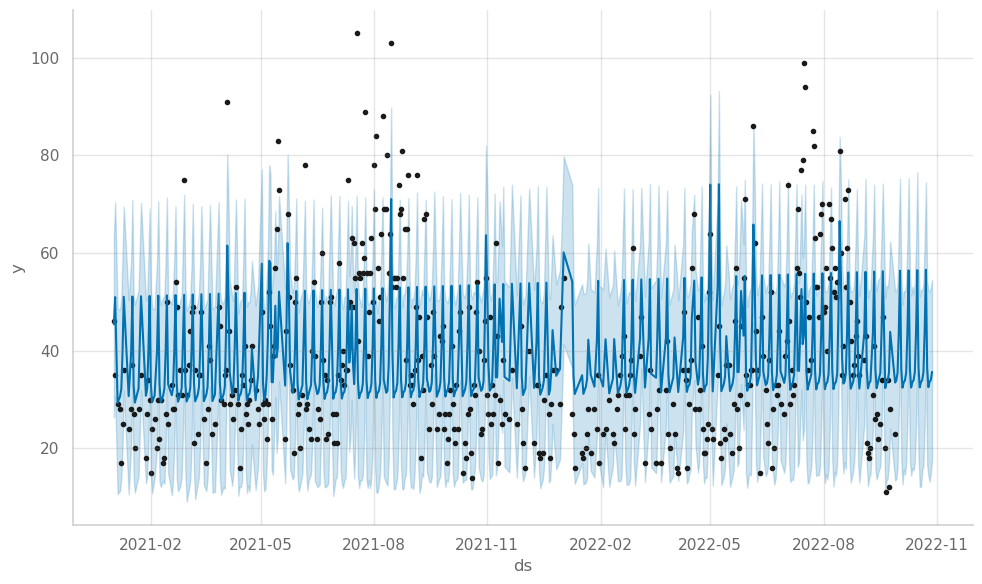

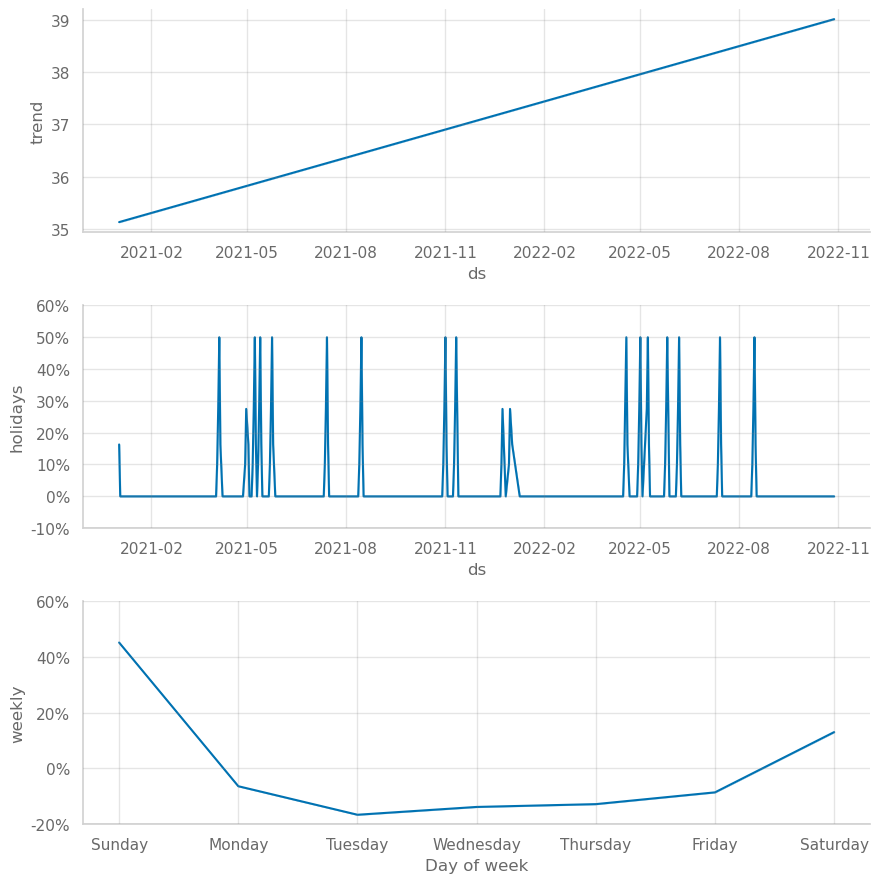

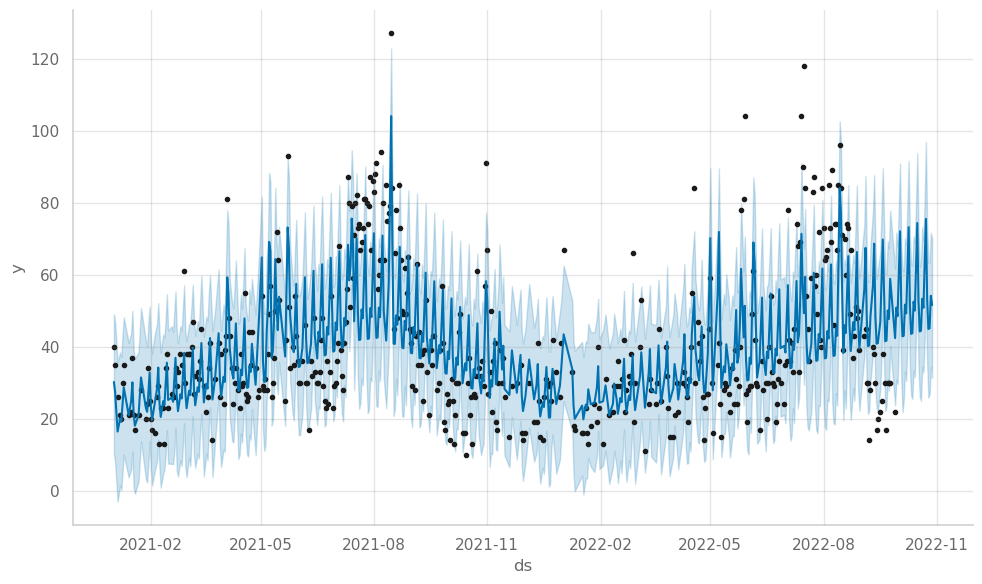

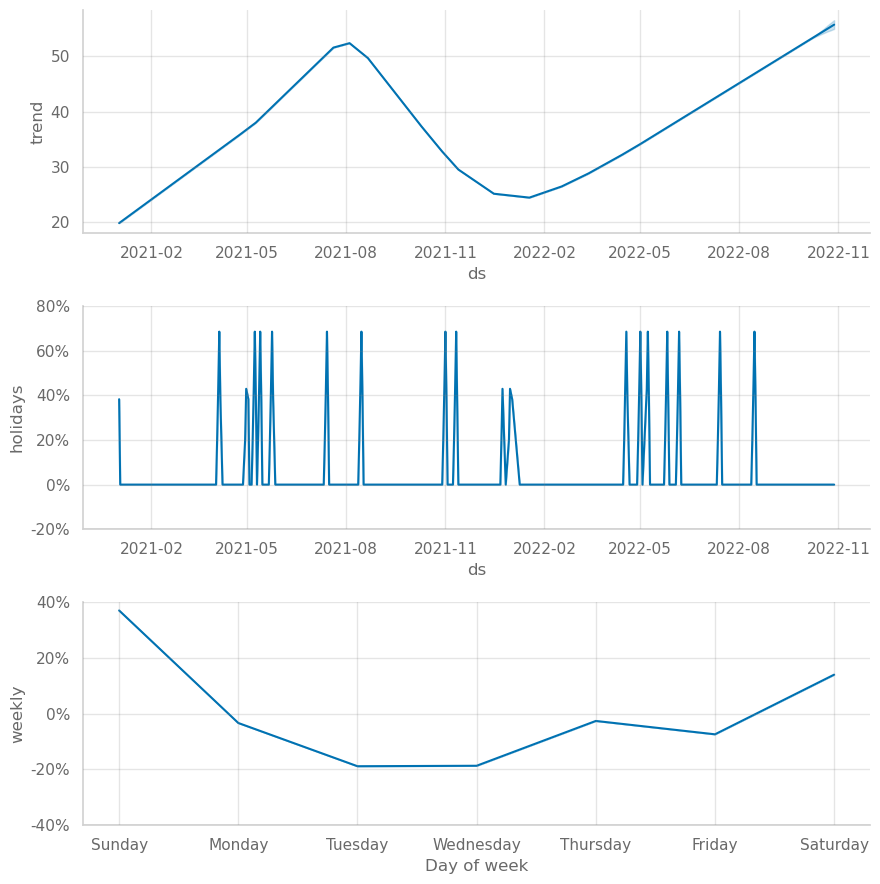

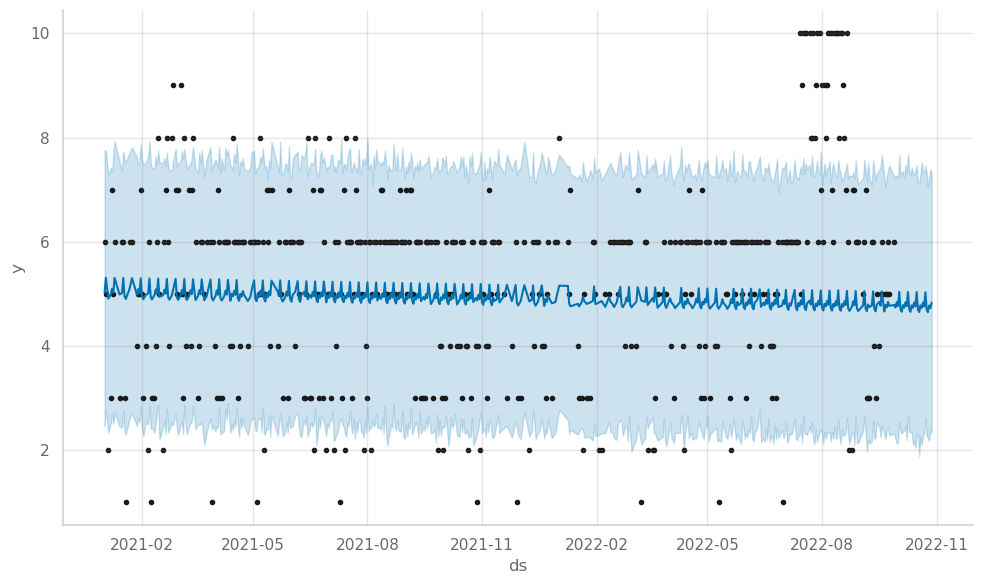

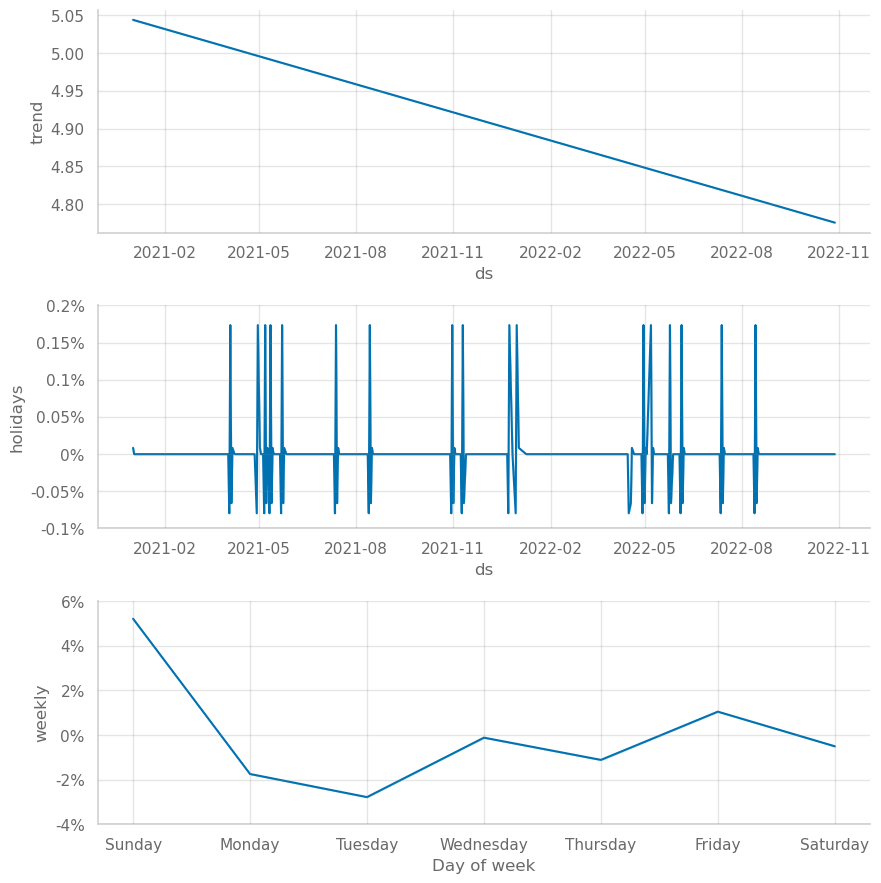

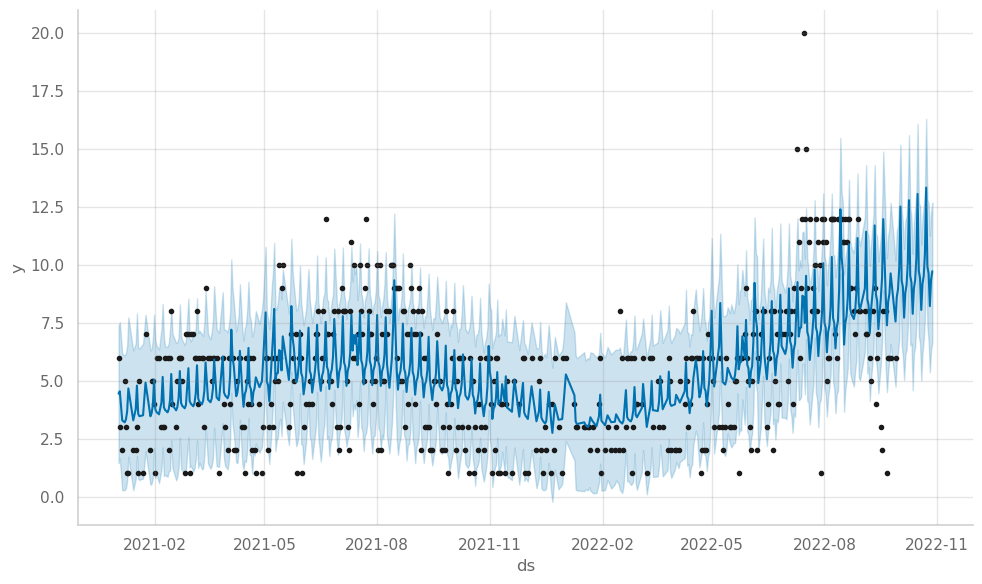

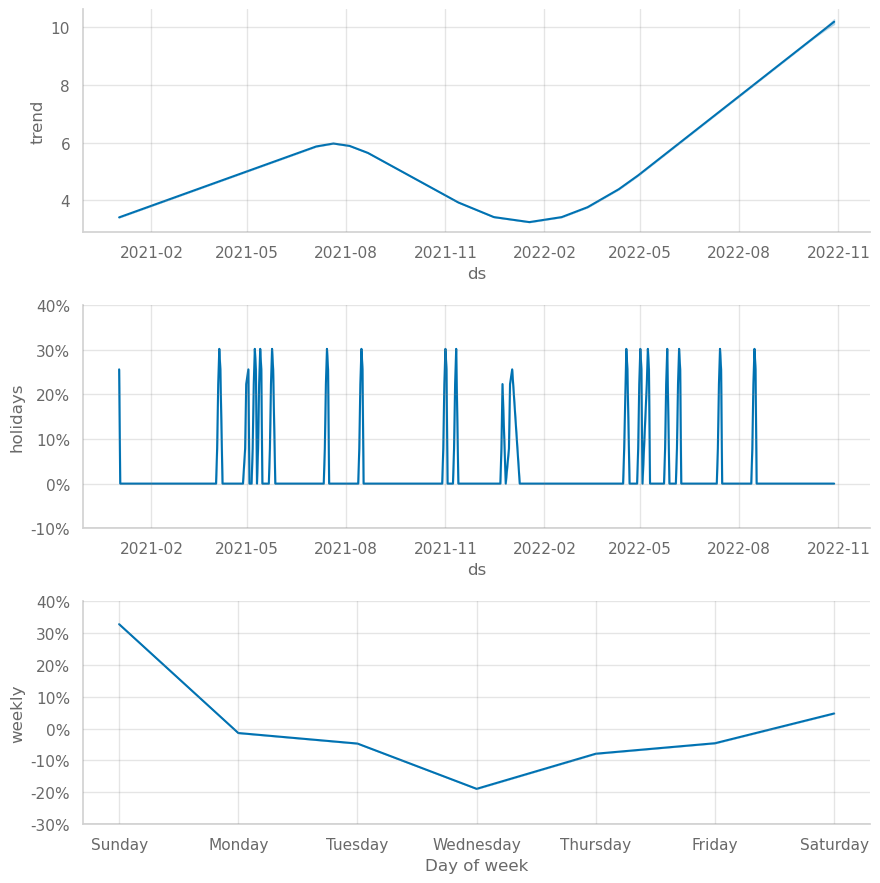

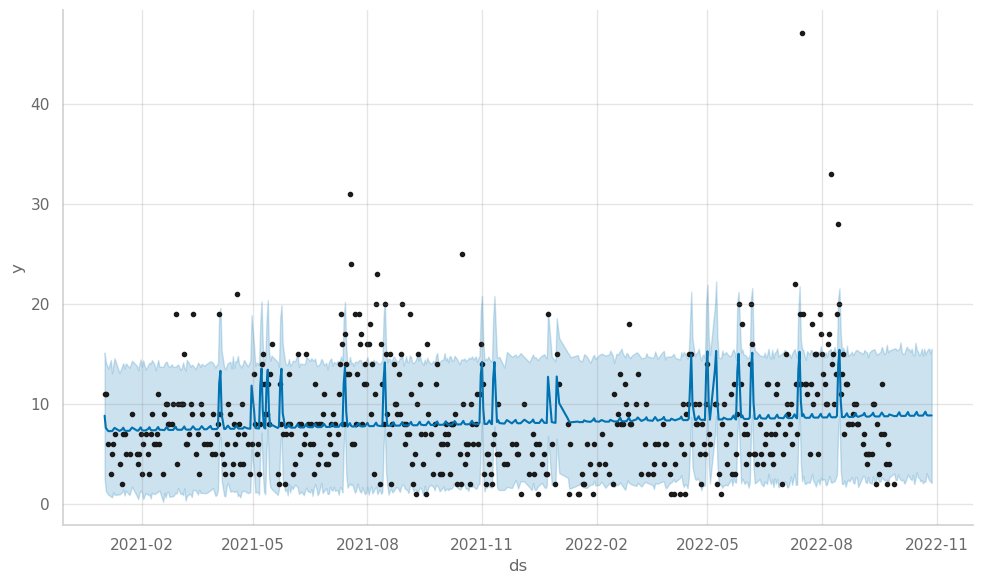

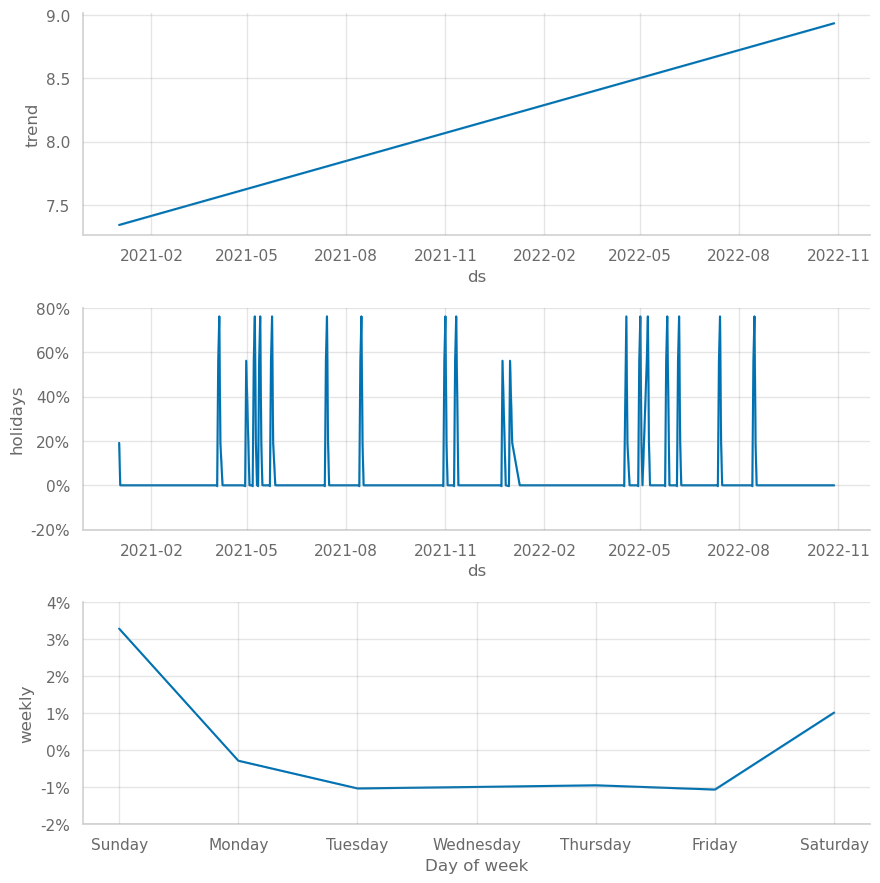

In [41]:
# Load trained models
with open('trained_prophet_models_bakeries.pkl', 'rb') as f:
    trained_models = pickle.load(f)

forecasted_dfs = []

for m in trained_models:
    future = m.make_future_dataframe(periods=30)
    fcst_prophet_train = m.predict(future)
    plt.rcParams['font.family'] = 'sans-serif' 
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [38]:
# Print only the predicted sales data
for forecasted_df in forecasted_dfs:
    print(forecasted_df[['ds', 'yhat']])

Empty DataFrame
Columns: [ds, yhat]
Index: []
Empty DataFrame
Columns: [ds, yhat]
Index: []
Empty DataFrame
Columns: [ds, yhat]
Index: []
Empty DataFrame
Columns: [ds, yhat]
Index: []
Empty DataFrame
Columns: [ds, yhat]
Index: []


In [43]:
forecasted_df.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'FR-Holidays', 'FR-Holidays_lower', 'FR-Holidays_upper', 'holidays',
       'holidays_lower', 'holidays_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')

In [42]:
item_names = ['BAGUETTE', 'BANETTE', 'BANETTINE', 'BOULE 200G', 'BOULE 400G',
       'CAMPAGNE', 'CEREAL BAGUETTE', 'COMPLET', 'COOKIE', 'COUPE',
       'CROISSANT', 'FICELLE', 'MOISSON', 'PAIN', 'PAIN AU CHOCOLAT',
       'PAIN AUX RAISINS', 'PAIN BANETTE', 'SPECIAL BREAD',
       'TRADITIONAL BAGUETTE']

# List to store data for the new DataFrame
data = []

# Iterate through forecasted_dfs
for i, forecasted_df in enumerate(forecasted_dfs):
    # Calculate the sum of yhat values
    total_sales = forecasted_df['yhat'].sum()
    # Get the item name based on index
    item_name = item_names[i]
    # Append data to the list
    data.append({"item": item_name, "total_sales": total_sales})

# Create DataFrame from the list
sales_df = pd.DataFrame(data)

print(sales_df)


         item  total_sales
0    BAGUETTE      1125.69
1     BANETTE      1562.85
2   BANETTINE       138.71
3  BOULE 200G       283.28
4  BOULE 400G       258.08


#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)